# Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import copy
import pathlib

from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

try:
    import lightgbm as lgb
except:
    print("lightgbm is not installed")

DATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/joined_left_CMAQ.csv"
STATION_IDS = [211, 212, 213, 214, 215, 216]

BASE_FEATURE_COLS = [
    "NO2_cmaq",
    "NO_cmaq",
    "O3_cmaq",
]

# Define lag and rolling windows for feature engineering
LAG_STEPS = [3, 6, 12, 24]
ROLL_WINDOWS = [3, 6, 12, 24]

# Define horizon (= n_past = n_future)
HORIZONS = [1, 24, 48, 72]

RANDOM_STATE = 42

# Directory to save the results and meta data
LIGHTGBM_DIR = f"/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/{datetime.now(timezone('Asia/Saigon')).strftime('%Y_%m_%d-%H_%M_%S')}"
pathlib.Path(LIGHTGBM_DIR).mkdir(parents=True, exist_ok=True)
print(LIGHTGBM_DIR)
with open(os.path.join(LIGHTGBM_DIR, "CONFIGURATIONS.txt"), "w") as f:
    f.write(f"BASE_FEATURE_COLS: {BASE_FEATURE_COLS}\n")
    f.write(f"LAG_STEPS: {LAG_STEPS}\n")
    f.write(f"ROLL_WINDOWS: {ROLL_WINDOWS}\n")
    f.write(f"HORIZONS: {HORIZONS}\n")
    f.write(f"RANDOM_STATE: {RANDOM_STATE}\n")

/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/2025_12_13-13_39_15


# Load dataset

In [2]:
# Load dataset
df_all = pd.read_csv("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/joined_left_CMAQ.csv")

# Rename columns
df_all = df_all.rename({"Datetime": "date", "Station": "station_id"}, axis=1)
df_all = df_all.rename({c: c + "_cmaq" for c in df_all.columns if c not in ["date", "station_id"]}, axis=1)

# Set datetime
df_all["date"] = pd.to_datetime(df_all["date"])

# Sort data by station then date
df_all = df_all.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_all = df_all.loc[:, ["date"] + BASE_FEATURE_COLS + ["station_id"]]

print(df_all.shape)
print(df_all.columns)
print(df_all.dtypes)
df_all

(52332, 5)
Index(['date', 'NO2_cmaq', 'NO_cmaq', 'O3_cmaq', 'station_id'], dtype='object')
date          datetime64[ns]
NO2_cmaq             float64
NO_cmaq              float64
O3_cmaq              float64
station_id             int64
dtype: object


date  NO2_cmaq   NO_cmaq   O3_cmaq  station_id
0     2022-01-01 07:00:00  0.001115       NaN  0.098301         201
1     2022-01-01 08:00:00  0.001141       NaN  0.078072         201
2     2022-01-01 09:00:00  0.000941       NaN  0.061198         201
3     2022-01-01 10:00:00  0.000761       NaN  0.050983         201
4     2022-01-01 11:00:00  0.000600       NaN  0.042117         201
...                   ...       ...       ...       ...         ...
52327 2022-12-31 01:00:00  0.002276  0.000013  0.026421         216
52328 2022-12-31 02:00:00  0.002208  0.000013  0.026171         216
52329 2022-12-31 03:00:00  0.002249  0.000013  0.026087         216
52330 2022-12-31 04:00:00  0.002680  0.000013  0.026347         216
52331 2022-12-31 05:00:00  0.002590  0.000013  0.026102         216

[52332 rows x 5 columns]

In [3]:
df_all.isnull().sum()

date             0
NO2_cmaq         0
NO_cmaq       7637
O3_cmaq          0
station_id       0
dtype: int64

# Data preparation

## Drop missing

Output: df_dropped

In [4]:
df_dropped = df_all.dropna().reset_index(drop=True)
df_dropped

date  NO2_cmaq   NO_cmaq   O3_cmaq  station_id
0     2022-01-02 00:00:00  0.006081  0.000046  0.026999         201
1     2022-01-02 01:00:00  0.005674  0.000046  0.026982         201
2     2022-01-02 02:00:00  0.005318  0.000046  0.027042         201
3     2022-01-02 03:00:00  0.005780  0.000046  0.026666         201
4     2022-01-02 04:00:00  0.006130  0.000046  0.026523         201
...                   ...       ...       ...       ...         ...
44690 2022-12-31 01:00:00  0.002276  0.000013  0.026421         216
44691 2022-12-31 02:00:00  0.002208  0.000013  0.026171         216
44692 2022-12-31 03:00:00  0.002249  0.000013  0.026087         216
44693 2022-12-31 04:00:00  0.002680  0.000013  0.026347         216
44694 2022-12-31 05:00:00  0.002590  0.000013  0.026102         216

[44695 rows x 5 columns]

## Update the STATION_IDS after dropping missing

In [5]:
STATION_IDS = list(df_dropped["station_id"].unique())
STATION_IDS

[201, 211, 212, 213, 214, 215, 216]

## Visualization

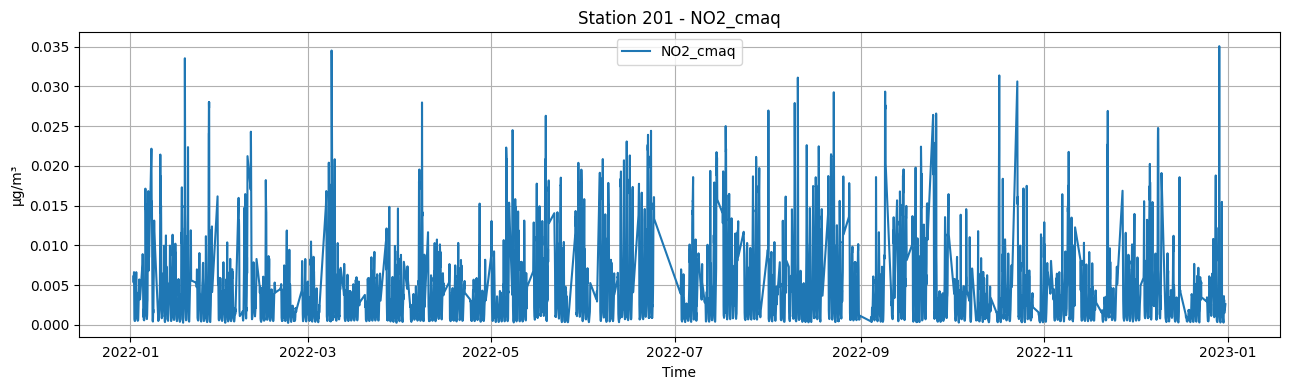

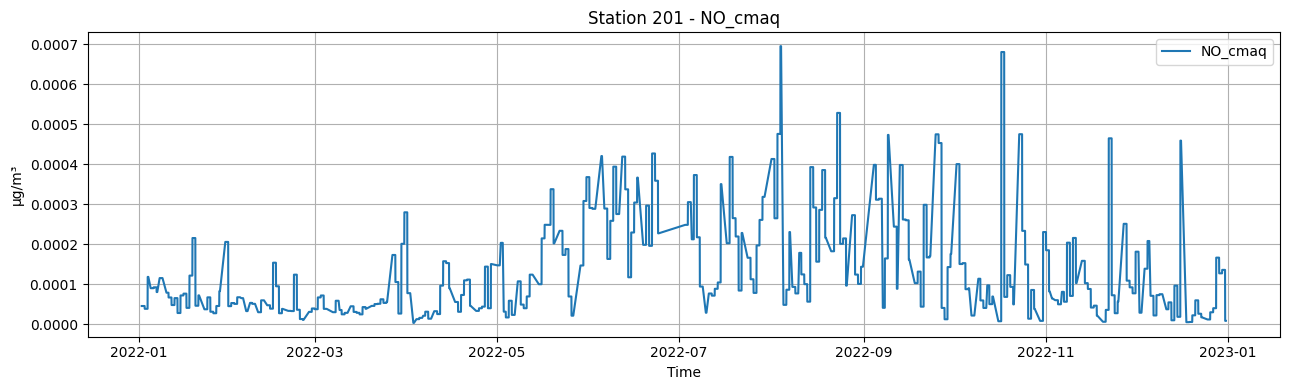

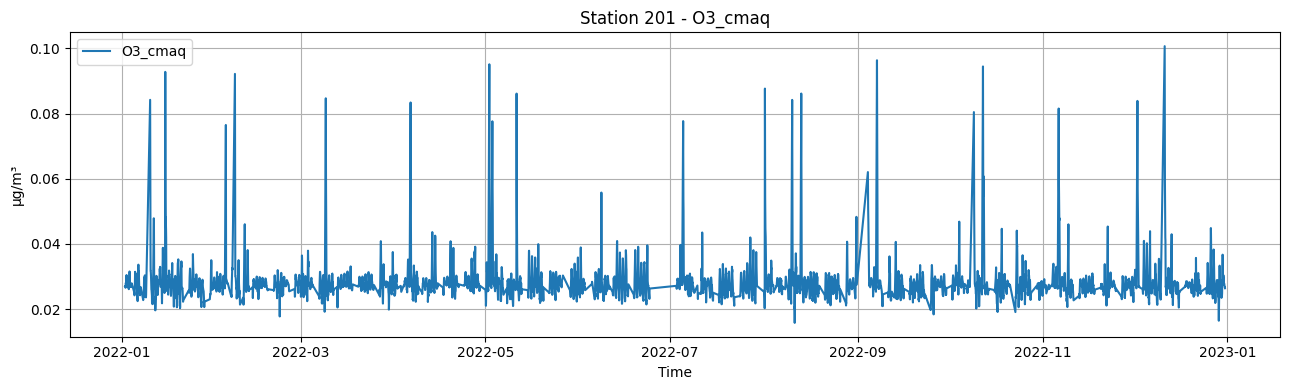

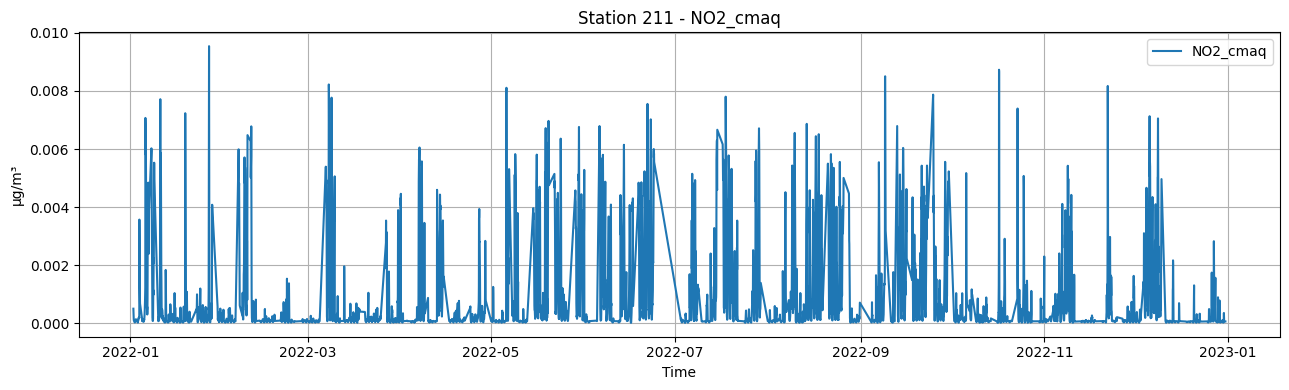

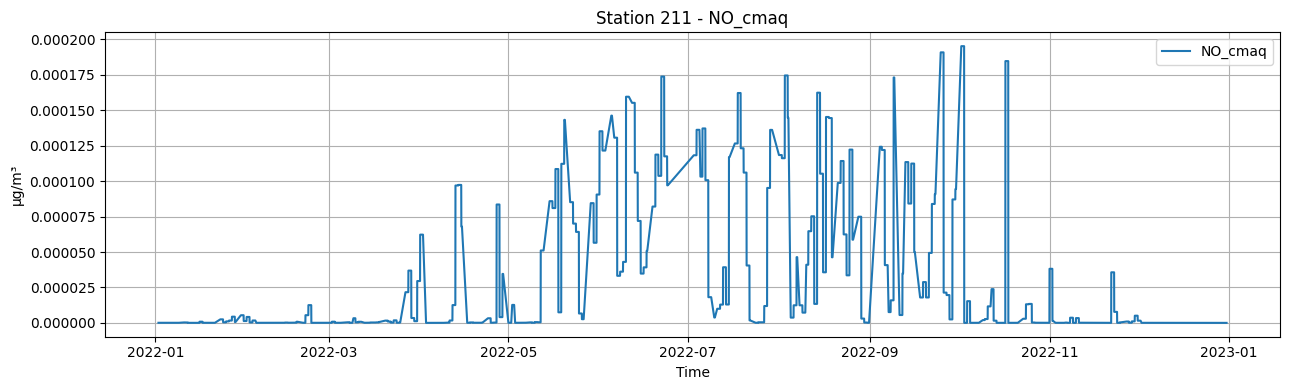

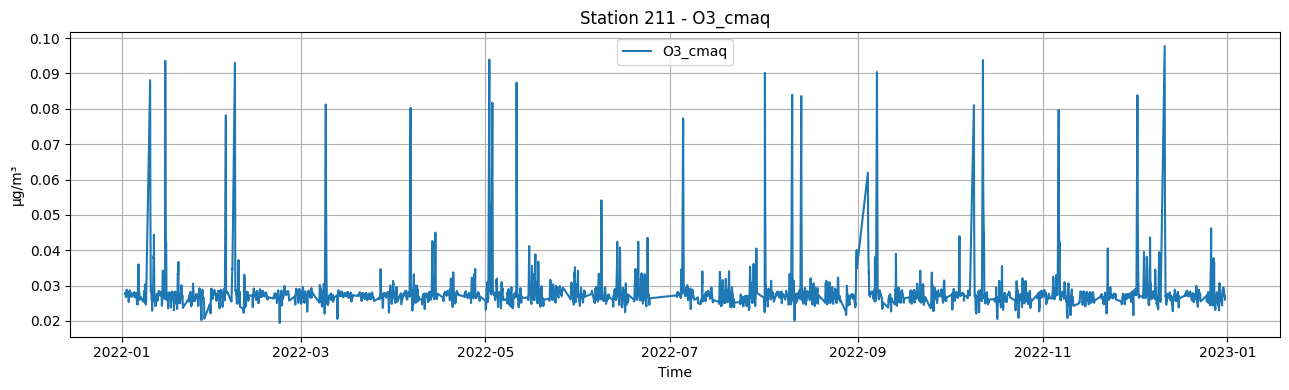

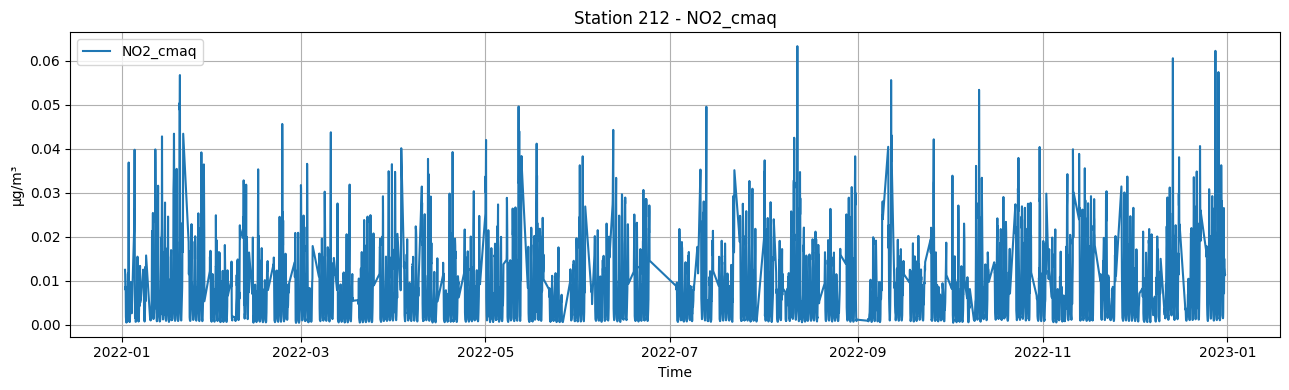

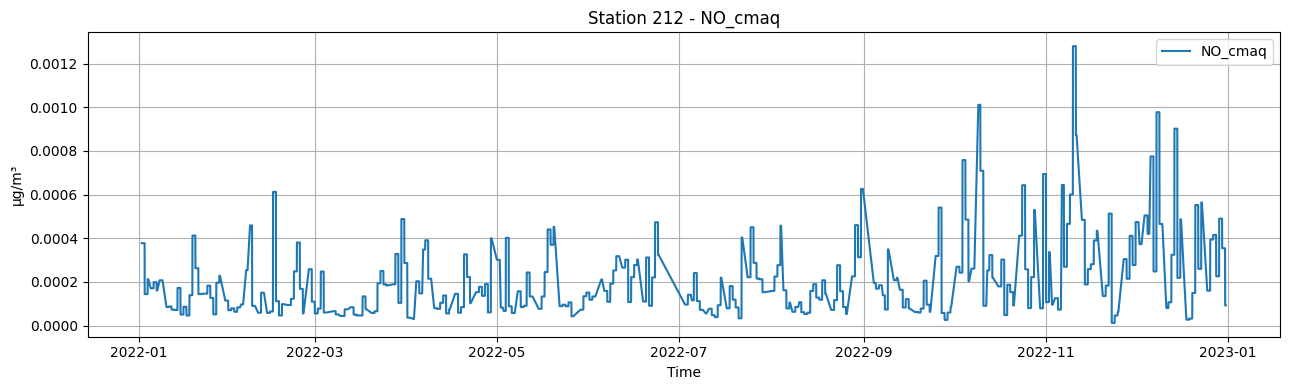

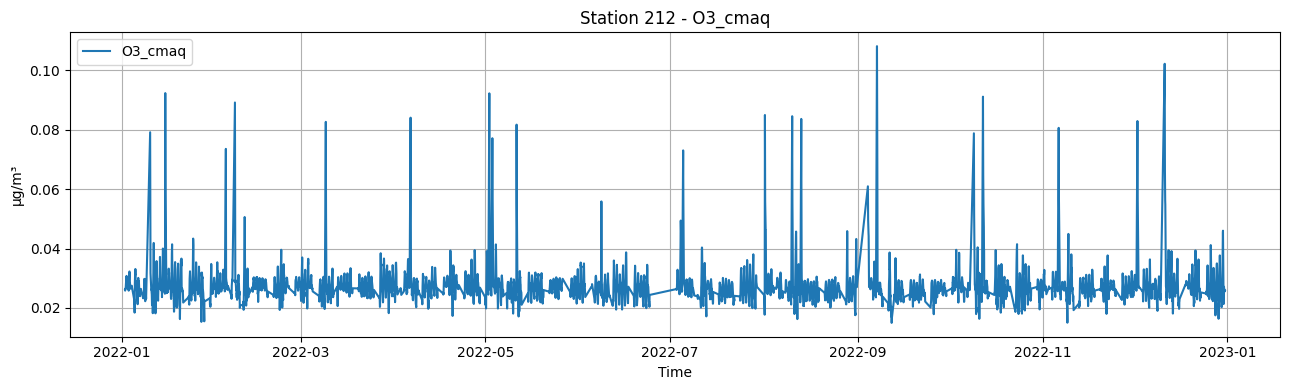

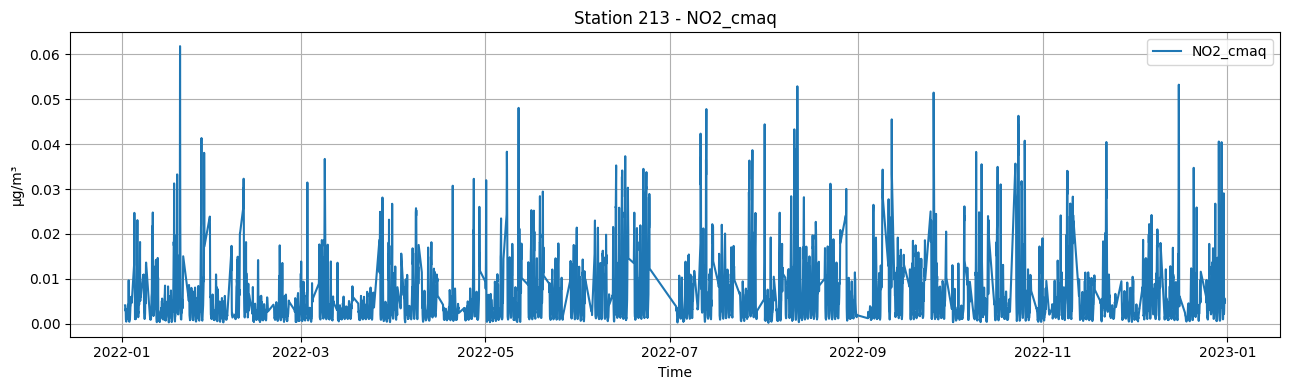

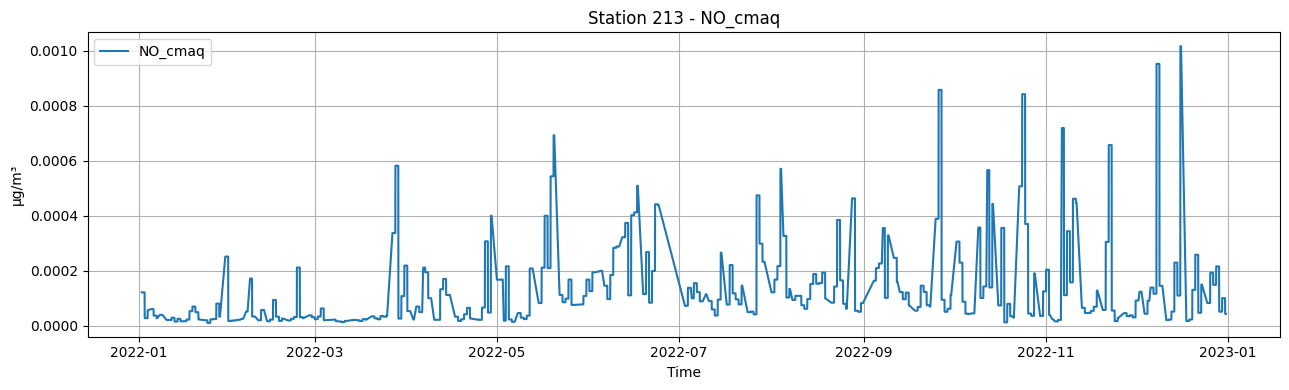

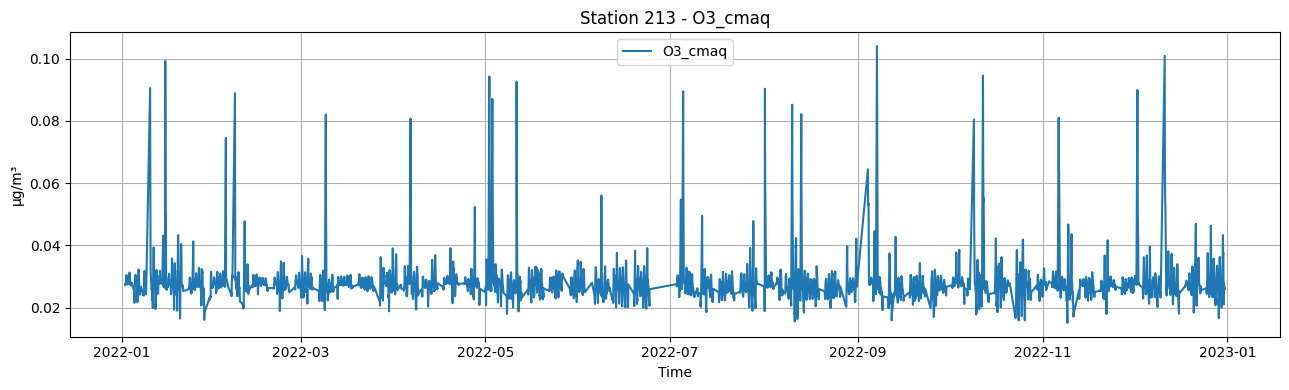

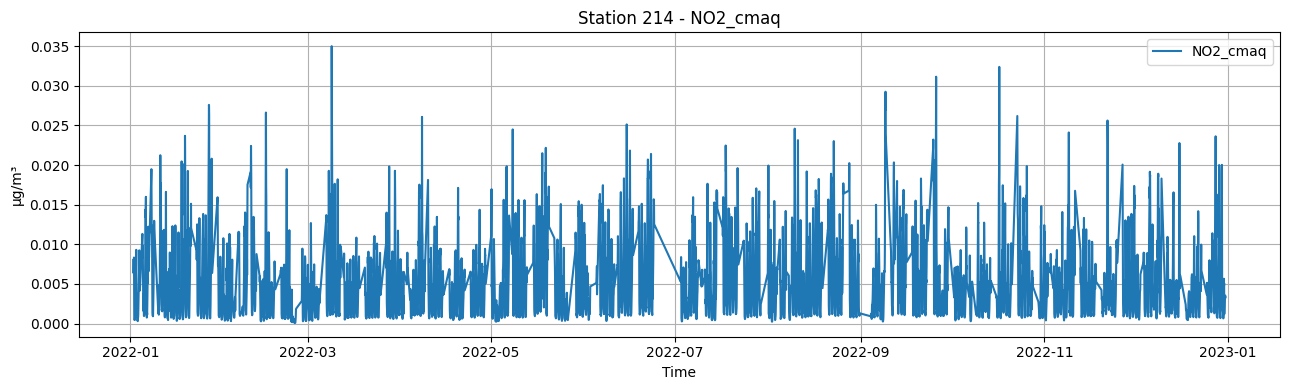

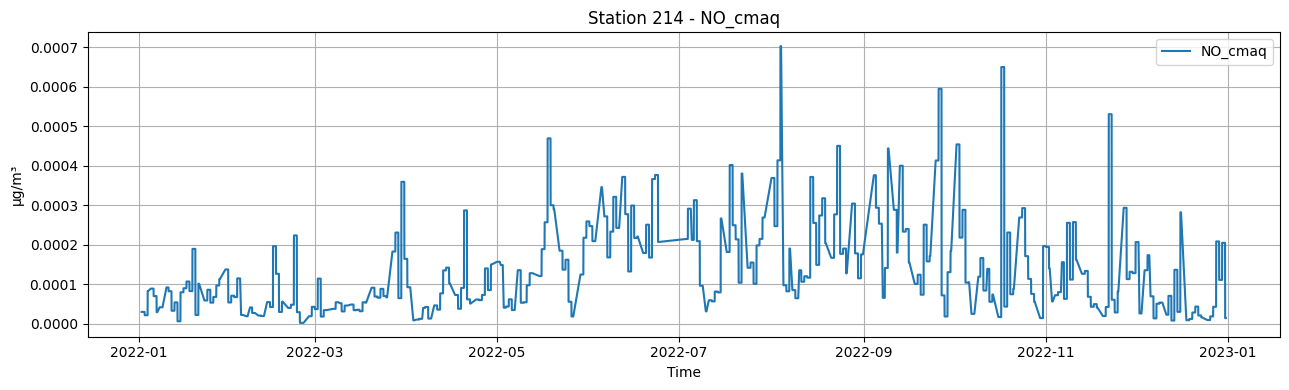

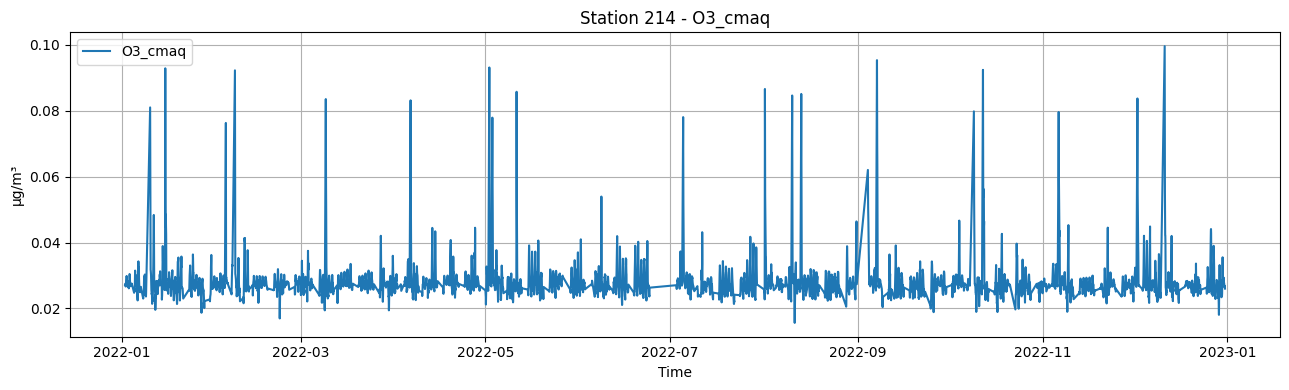

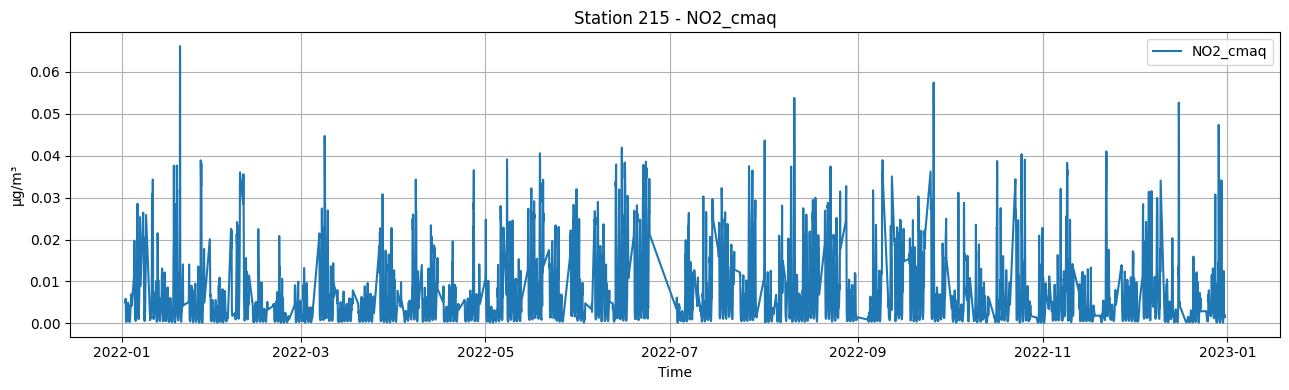

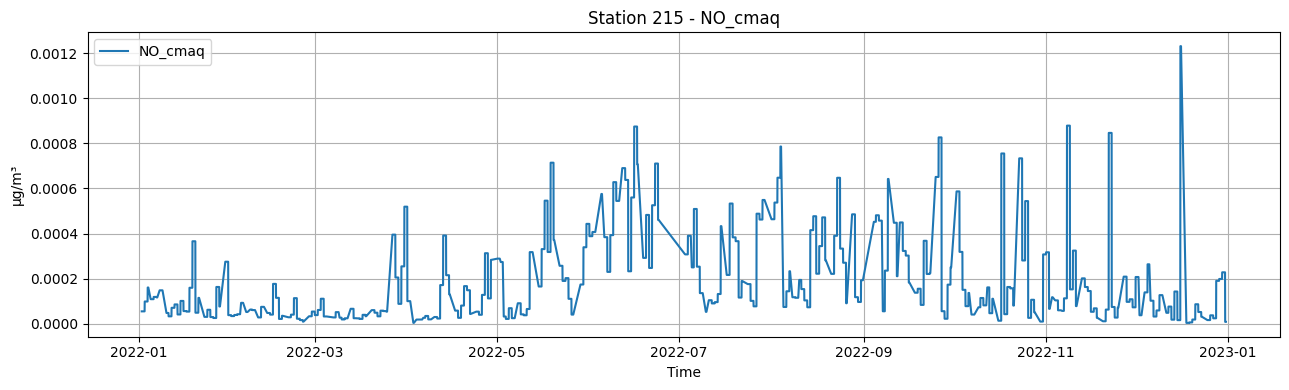

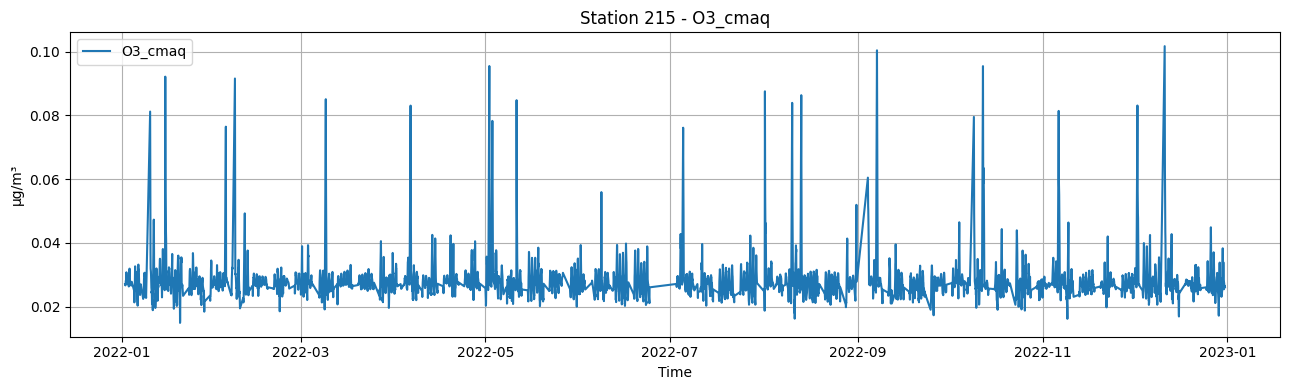

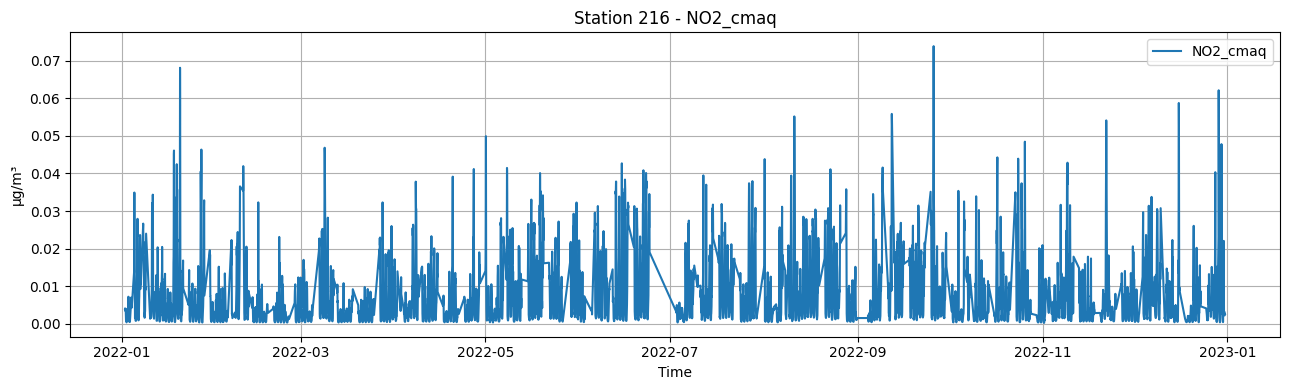

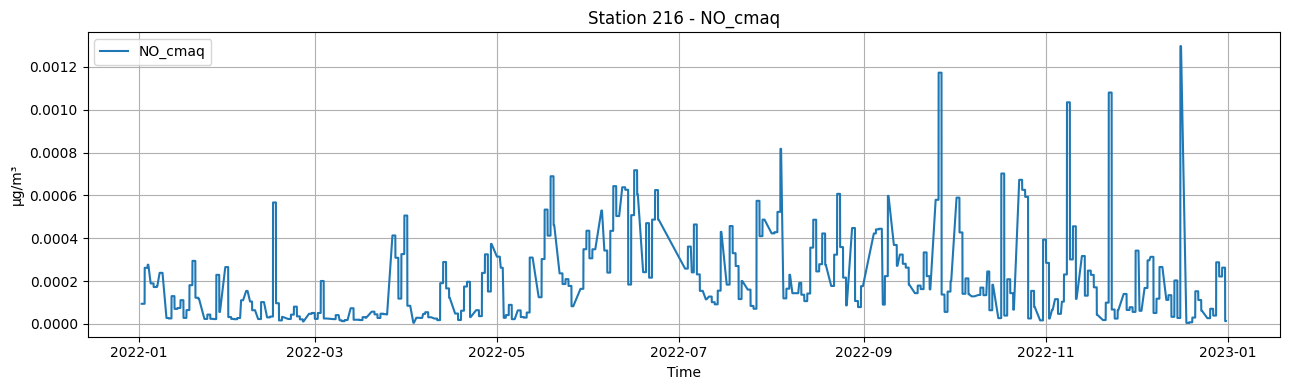

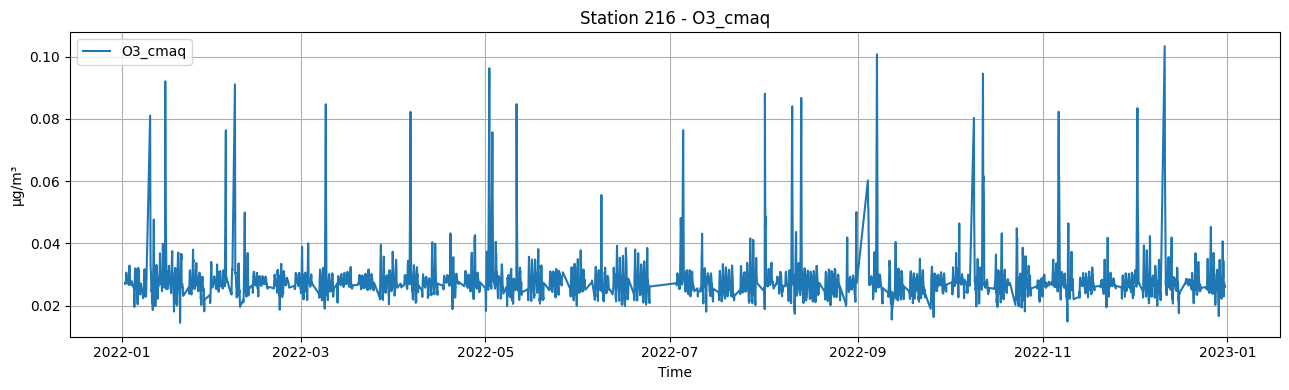

In [6]:
def plot_1_data(df, target_col, label, index, title, figsize=(13, 4)):
    plt.figure(figsize=figsize)
    plt.plot(index, df[target_col], label=label)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("µg/m³")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, target_col, df_station["date"], f"Station {station} - {target_col}")
            #plot_1_data(df_station, target_col, target_col, df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Convert ppm to ug/m3

Apply only to station 216, year 2022 on NO2, CO columns

Output: df_converted

In [7]:
df_converted = copy.deepcopy(df_dropped)
df_converted.loc[:, "NO2_cmaq"] = df_converted.loc[:, "NO2_cmaq"].apply(lambda x: x * 1883.2)
df_converted.loc[:, "O3_cmaq"] = df_converted.loc[:, "O3_cmaq"].apply(lambda x: x * 1963)
df_converted.loc[:, "NO_cmaq"] = df_converted.loc[:, "NO_cmaq"].apply(lambda x: x * 1228)
df_converted

date   NO2_cmaq   NO_cmaq    O3_cmaq  station_id
0     2022-01-02 00:00:00  11.451346  0.056415  52.999082         201
1     2022-01-02 01:00:00  10.684879  0.056415  52.966078         201
2     2022-01-02 02:00:00  10.015549  0.056415  53.082975         201
3     2022-01-02 03:00:00  10.884442  0.056415  52.346179         201
4     2022-01-02 04:00:00  11.543206  0.056415  52.063844         201
...                   ...        ...       ...        ...         ...
44690 2022-12-31 01:00:00   4.285888  0.016275  51.864199         216
44691 2022-12-31 02:00:00   4.157322  0.016275  51.373838         216
44692 2022-12-31 03:00:00   4.235773  0.016275  51.208808         216
44693 2022-12-31 04:00:00   5.047855  0.016275  51.719656         216
44694 2022-12-31 05:00:00   4.876919  0.016275  51.238619         216

[44695 rows x 5 columns]

## Visualization after converting unit

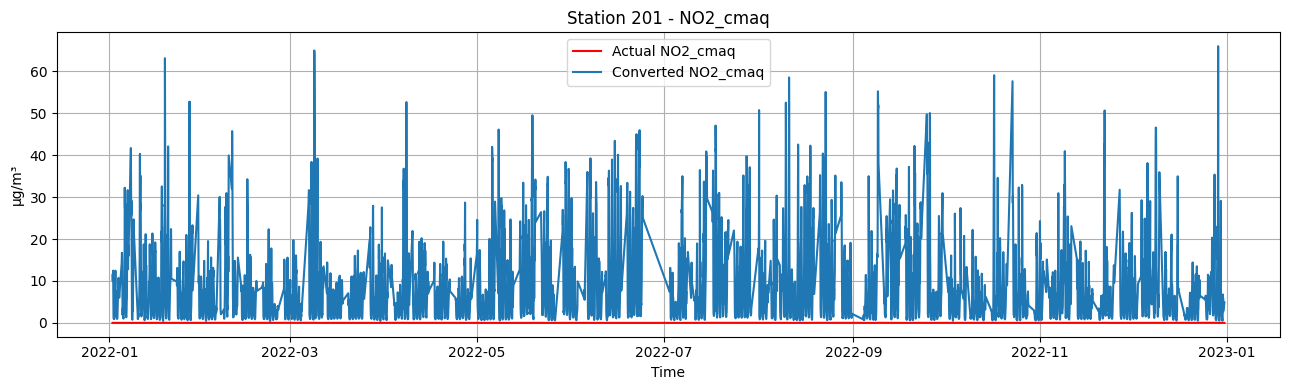

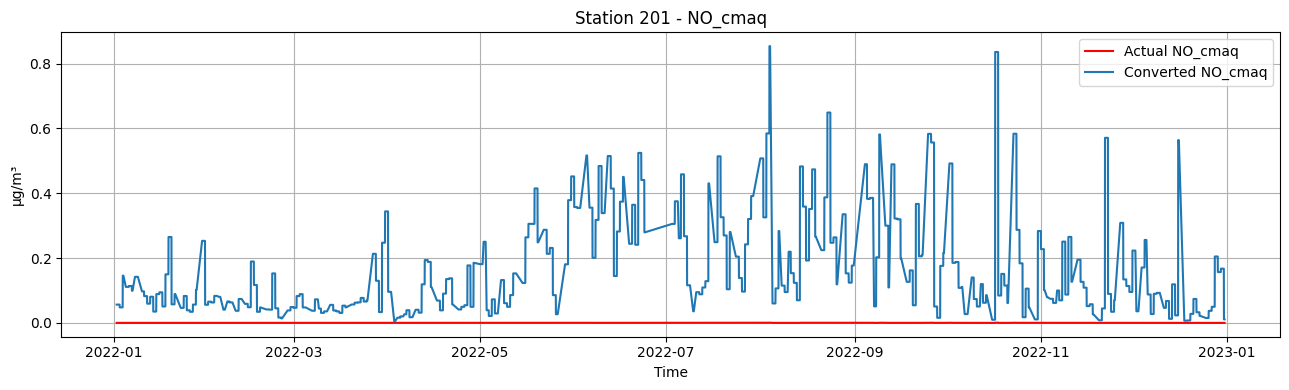

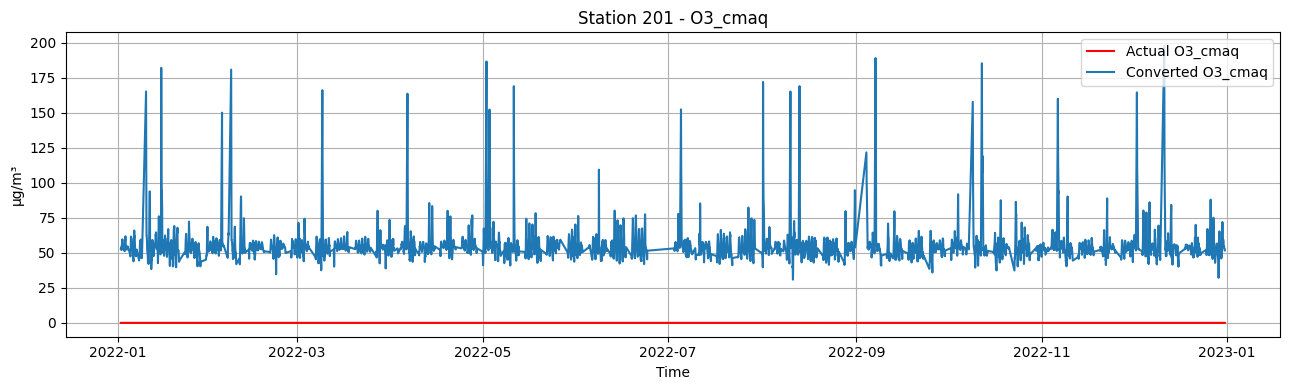

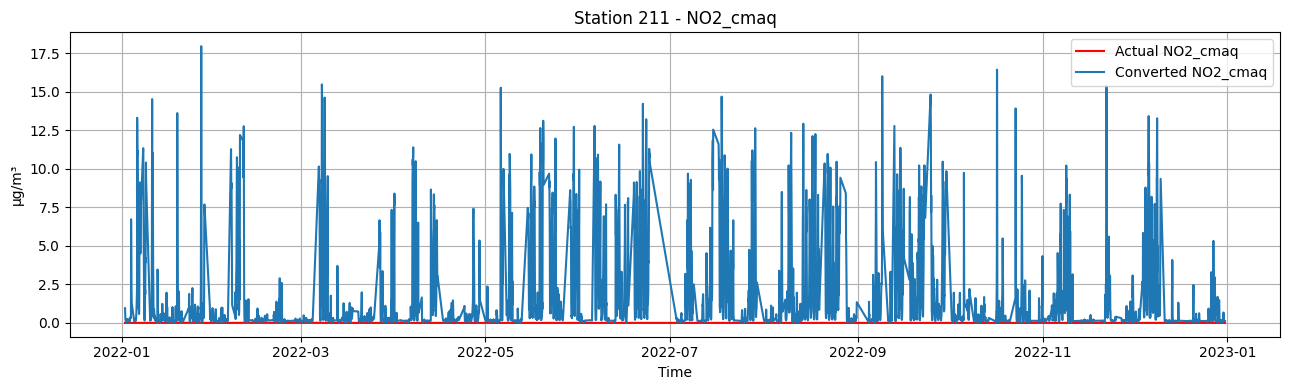

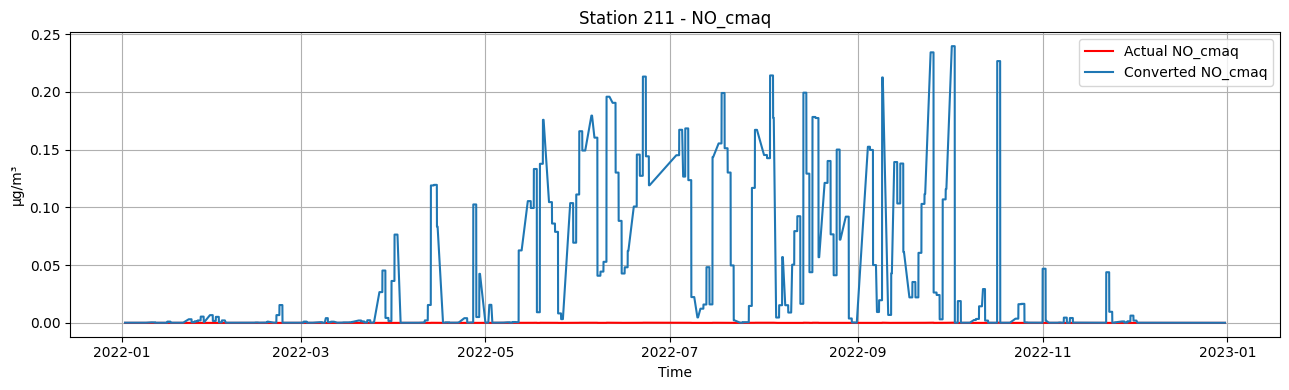

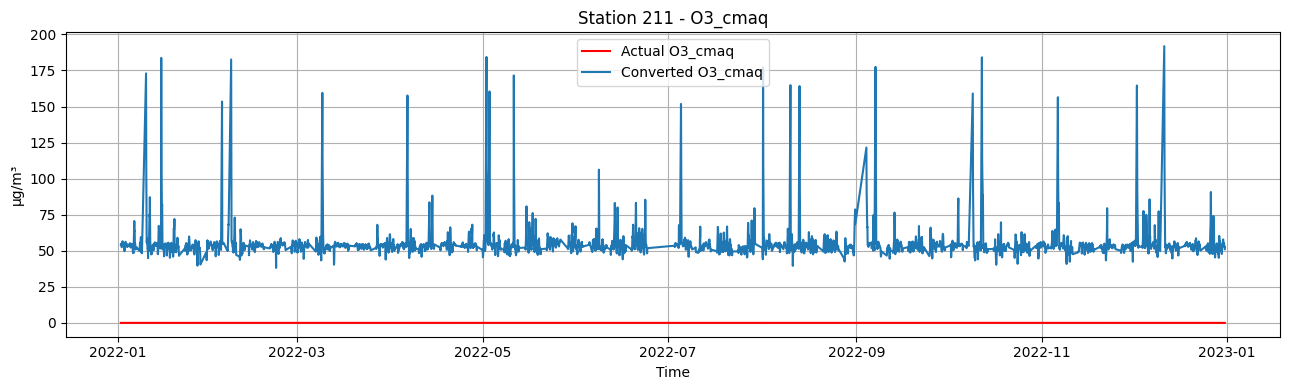

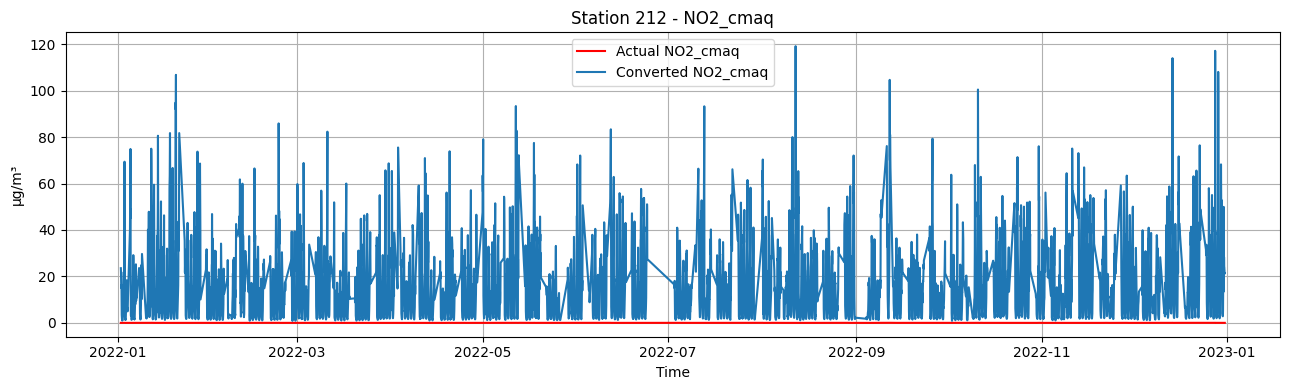

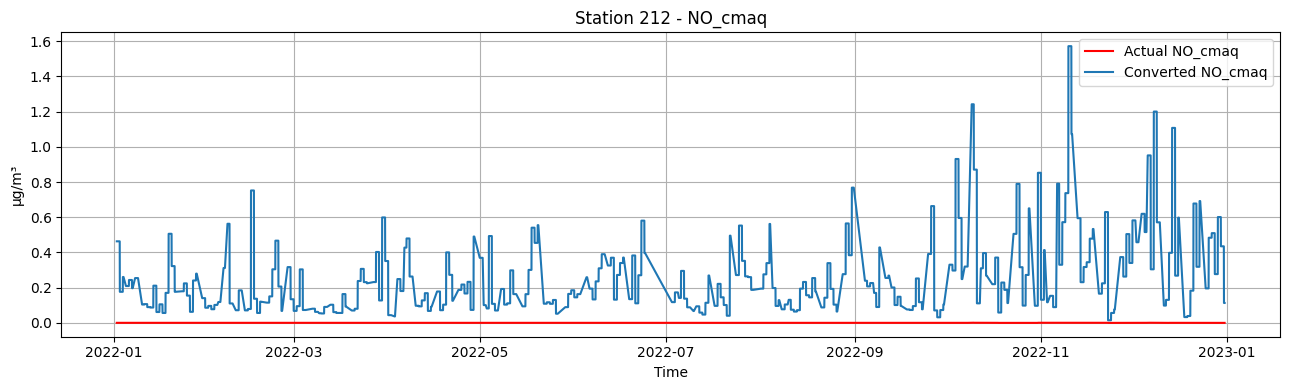

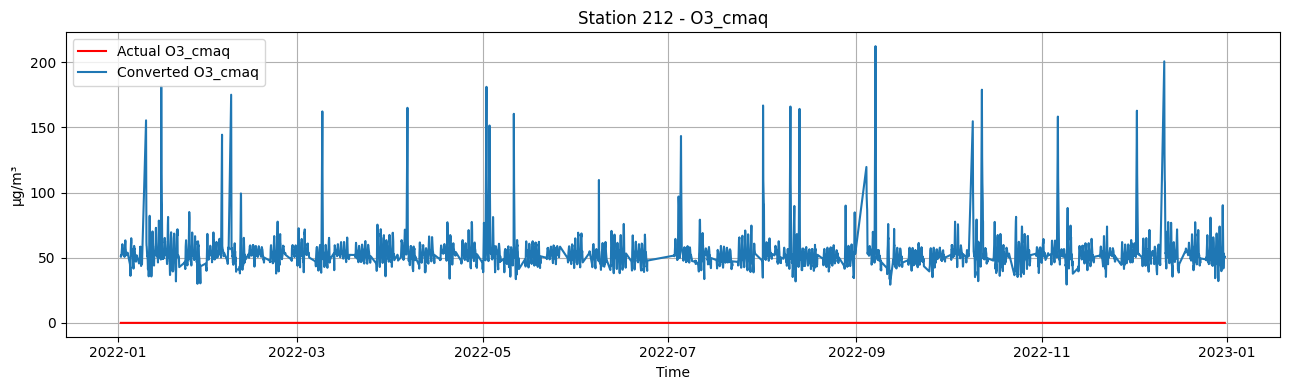

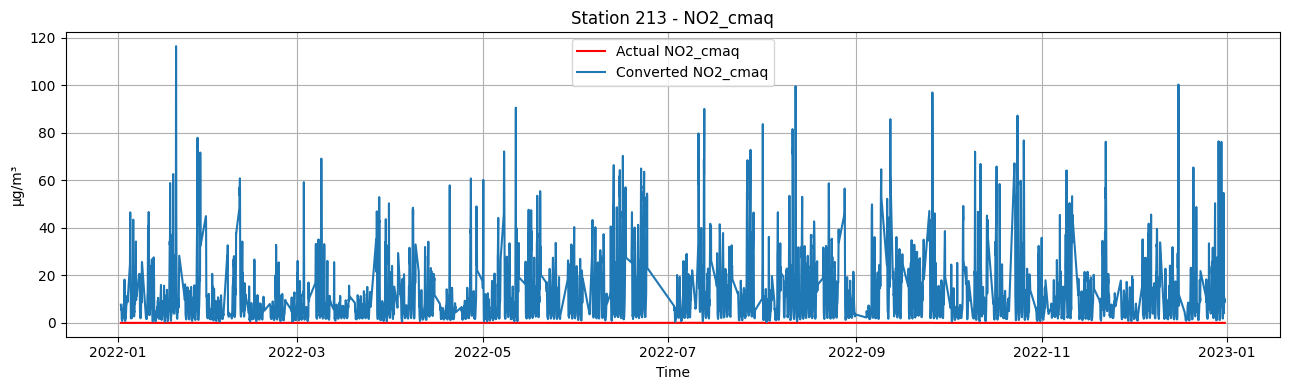

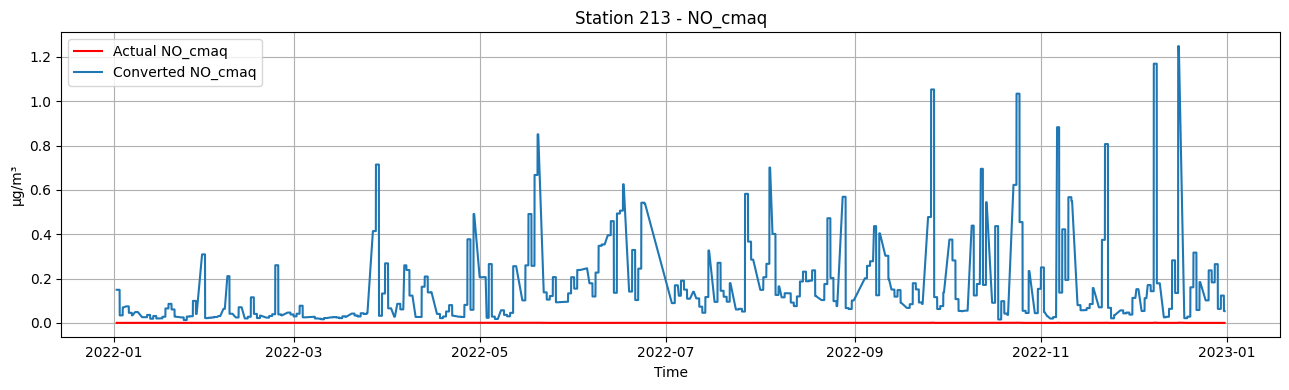

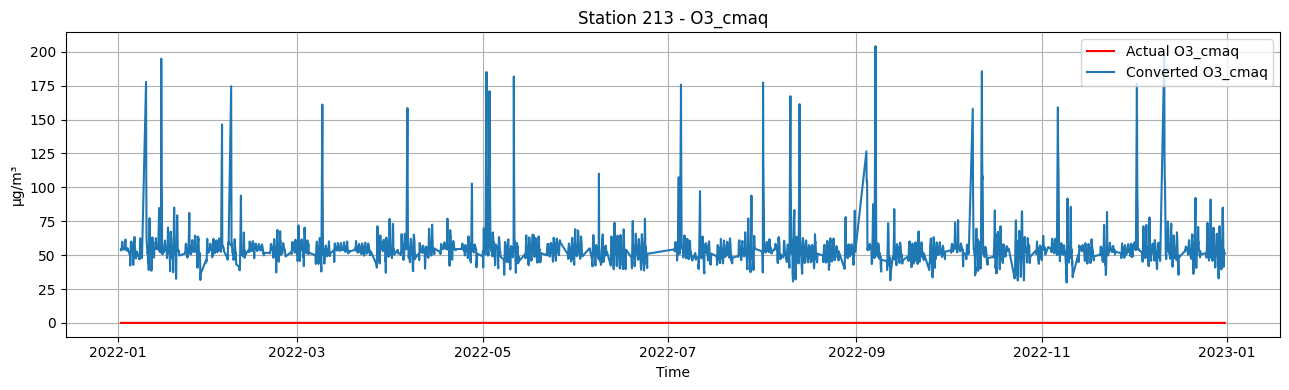

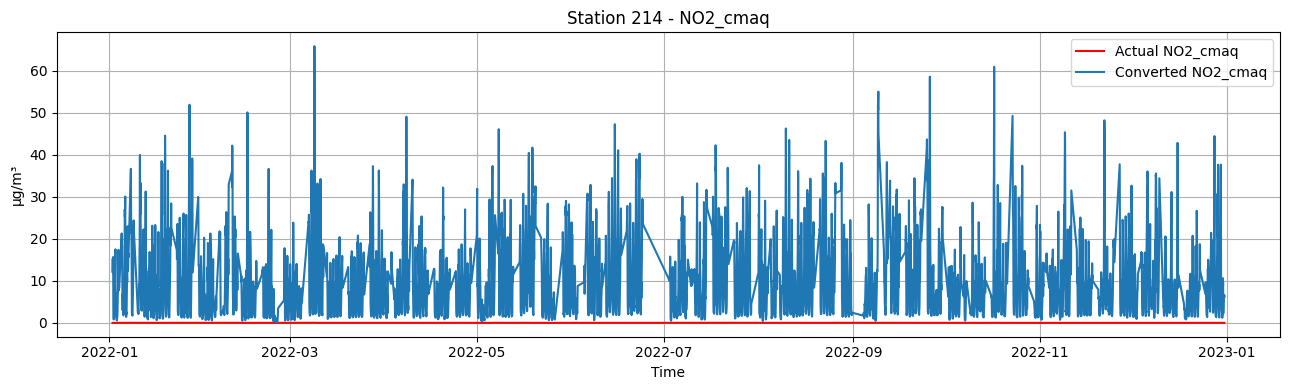

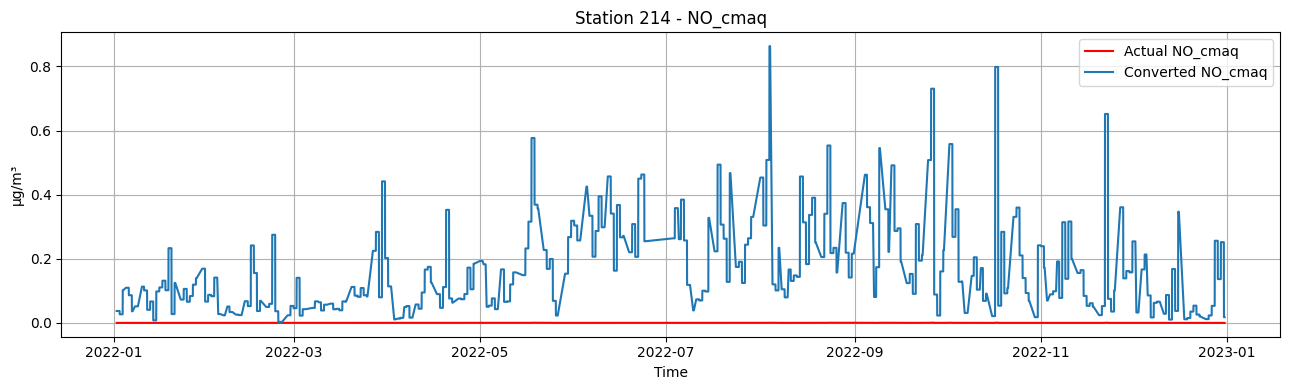

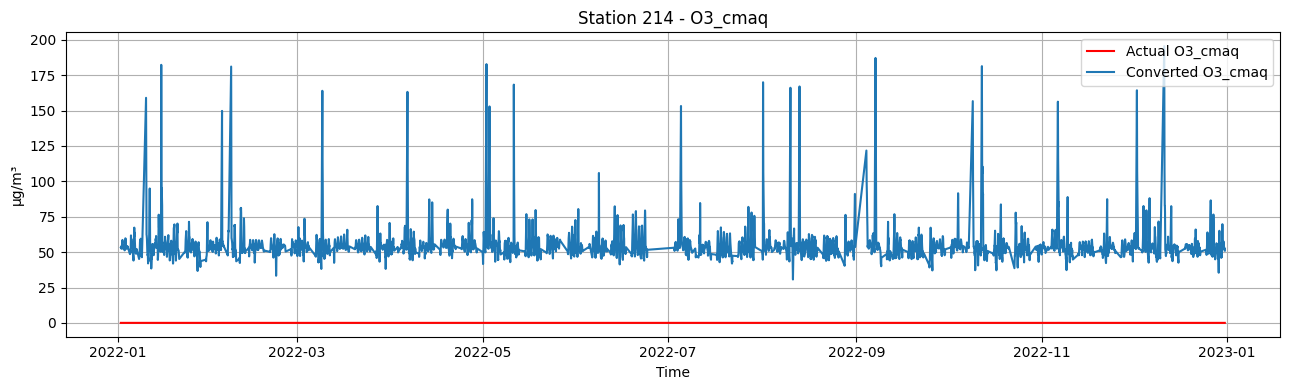

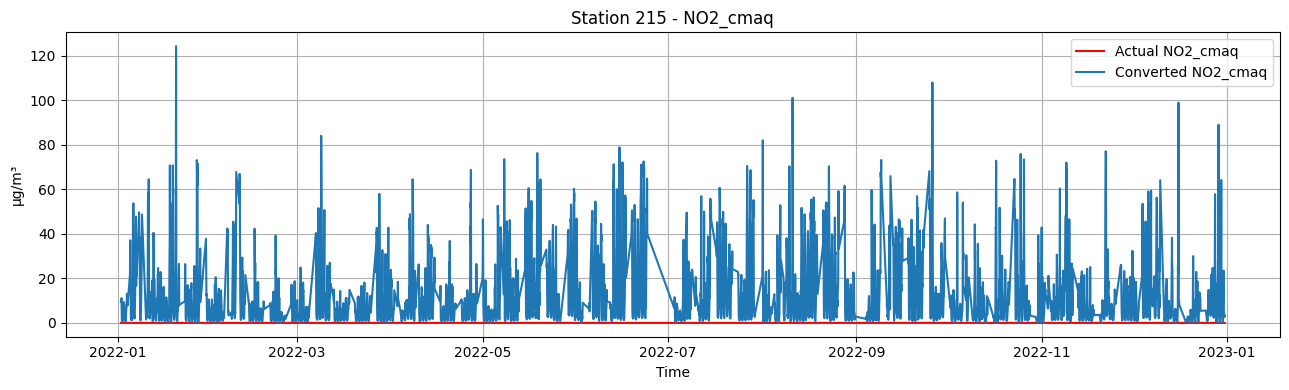

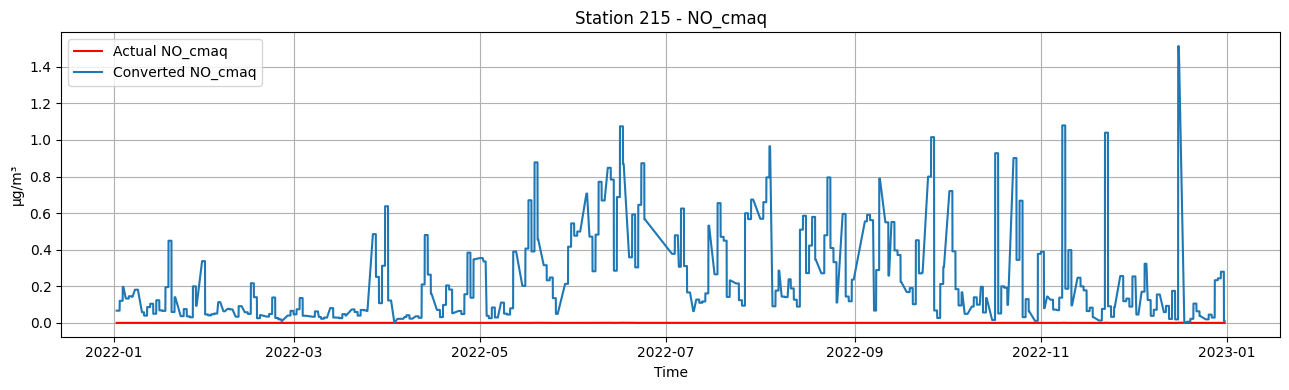

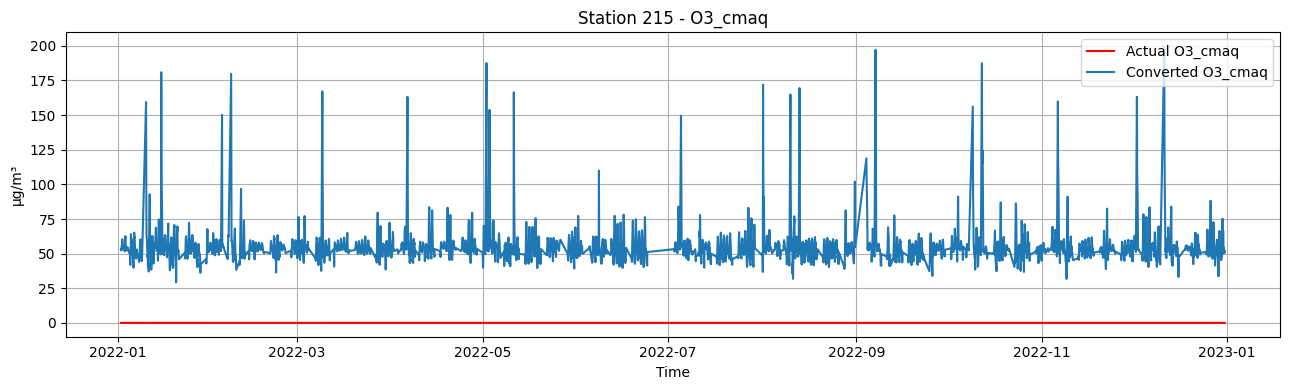

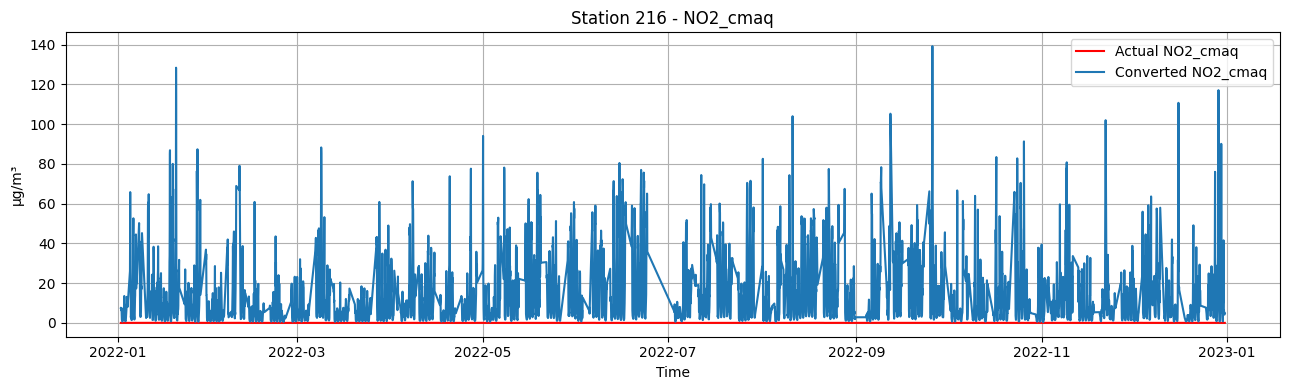

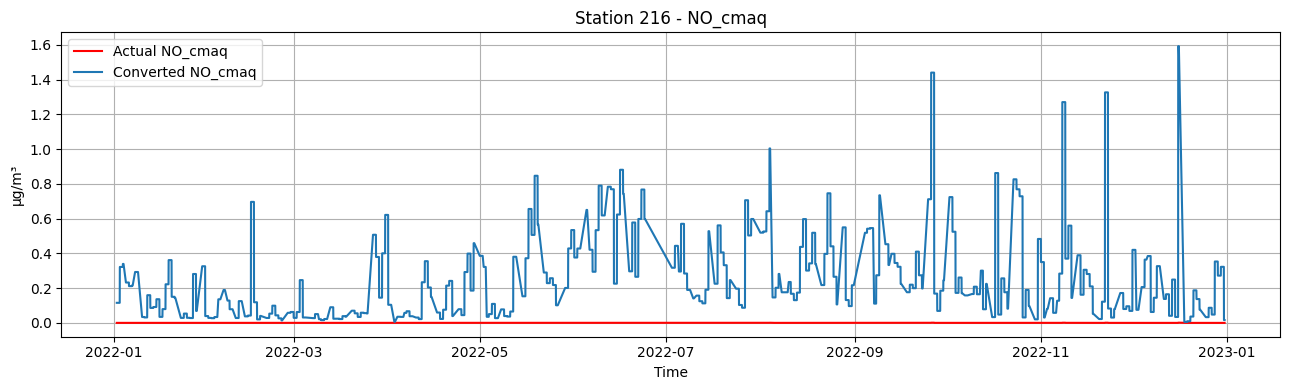

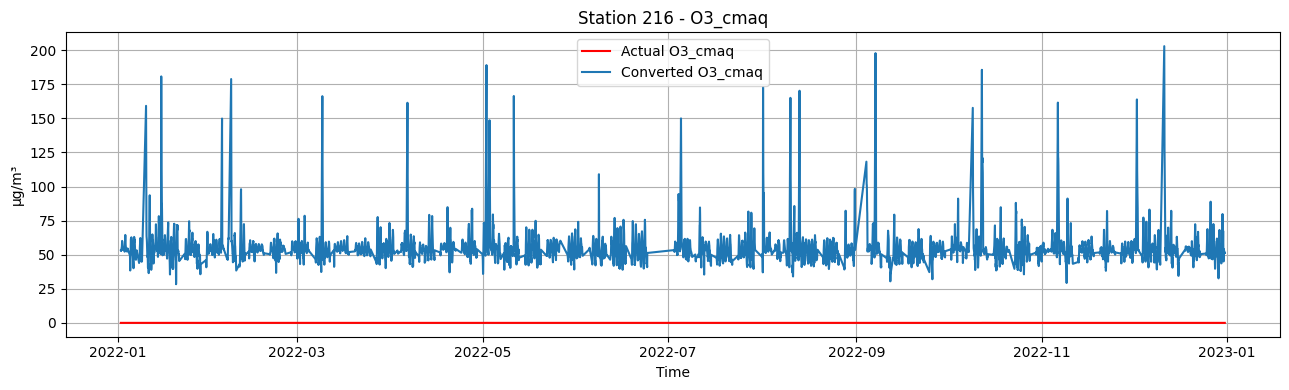

In [8]:
def plot_2_data(df1, target_col1, label1, df2, target_col2, label2, index, title, figsize=(13, 4)):
    plt.figure(figsize=figsize)
    plt.plot(index, df1[target_col1], label=label1, color="r")
    plt.plot(index, df2[target_col2], label=label2)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("µg/m³")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for station in STATION_IDS:
    df_station = df_dropped[df_dropped["station_id"] == station]
    df_station_converted = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_2_data(df_station, target_col, f"Actual {target_col}",
                        df_station_converted, target_col, f"Converted {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")

## Ugly hack to remove outliers

In [9]:
'''
test = copy.deepcopy(df_converted)

lenbefore = len(test)
print(f"Before: {lenbefore} records")

# 212 CO quantrac
test212 = test[test["station_id"] == 212]
test = test.drop(index=test212[test212["CO_quantrac"] > 4000].index)

# 213 CO quantrac
test213 = test[test["station_id"] == 213]
test = test.drop(index=test213[test213["CO_quantrac"] > 4000].index)

# 214 CO quantrac
test214 = test[test["station_id"] == 214]
test = test.drop(index=test214[test214["CO_quantrac"] > 4000].index)

# 215 NO2 quantrac
# 215 CO quantrac
test215 = test[test["station_id"] == 215]
test = test.drop(index=test215[test215["NO2_quantrac"] > 140].index)
test = test.drop(index=test215[test215["CO_quantrac"] > 2500].index)

# 216 CO quantrac
test216 = test[test["station_id"] == 216]
test = test.drop(index=test216[test216["CO_quantrac"] > 10000].index)

lenafter = len(test)
print(f"After: {lenafter} records")
print(f"Removed {lenbefore - lenafter} records")

df_converted = test.reset_index(drop=True)
'''

'\ntest = copy.deepcopy(df_converted)\n\nlenbefore = len(test)\nprint(f"Before: {lenbefore} records")\n\n# 212 CO quantrac\ntest212 = test[test["station_id"] == 212]\ntest = test.drop(index=test212[test212["CO_quantrac"] > 4000].index)\n\n# 213 CO quantrac\ntest213 = test[test["station_id"] == 213]\ntest = test.drop(index=test213[test213["CO_quantrac"] > 4000].index)\n\n# 214 CO quantrac\ntest214 = test[test["station_id"] == 214]\ntest = test.drop(index=test214[test214["CO_quantrac"] > 4000].index)\n\n# 215 NO2 quantrac\n# 215 CO quantrac\ntest215 = test[test["station_id"] == 215]\ntest = test.drop(index=test215[test215["NO2_quantrac"] > 140].index)\ntest = test.drop(index=test215[test215["CO_quantrac"] > 2500].index)\n\n# 216 CO quantrac\ntest216 = test[test["station_id"] == 216]\ntest = test.drop(index=test216[test216["CO_quantrac"] > 10000].index)\n\nlenafter = len(test)\nprint(f"After: {lenafter} records")\nprint(f"Removed {lenbefore - lenafter} records")\n\ndf_converted = test.res

## Visualization after removing outliers

In [10]:
'''
for station in STATION_IDS:
    df_station = df_converted[df_converted["station_id"] == station]
    for target_col in df_station.columns:
        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:
            plot_1_data(df_station, target_col, f"Actual {target_col}",
                        df_station["date"], f"Station {station} - {target_col}")
                        #df_station.index, f"Station {station} - {target_col}")
    print("\n" + "=" * 150 + "\n")
'''

'\nfor station in STATION_IDS:\n    df_station = df_converted[df_converted["station_id"] == station]\n    for target_col in df_station.columns:\n        if target_col not in ["date", "station_id", "Temperature_quantrac", "Humid_quantrac", "PM25_quantrac"]:\n            plot_1_data(df_station, target_col, f"Actual {target_col}",\n                        df_station["date"], f"Station {station} - {target_col}")\n                        #df_station.index, f"Station {station} - {target_col}")\n    print("\n" + "=" * 150 + "\n")\n'

## Feature engineering

In [11]:
def add_time_features(df, time_col="date"):
    df = df.copy()
    df["hour"] = df[time_col].dt.hour
    df["dayofweek"] = df[time_col].dt.dayofweek
    df["month"] = df[time_col].dt.month
    return df

# Add lag features for all FEATURES including LABEL
def add_lag_features(df, group_col, target_cols, lag_steps):
    df = df.copy()
    df = df.sort_values(["station_id", "date"])

    for col in target_cols:
        for lag in lag_steps:
            df[f"{col}_lag{lag}"] = df.groupby(group_col)[col].shift(lag)
    return df

# Just add the rolling features for LABEL
def add_rolling_features(df, group_col, target_cols, windows):
    assert isinstance(target_cols, list), "target_cols should be a list"

    df = df.copy()
    df = df.sort_values(["station_id", "date"])

    for col in target_cols:
        for w in windows:
            df[f"{col}_roll{w}_mean"] = (
                df.groupby(group_col)[col]
                  .shift(1) # use the past, avoid leaking
                  .rolling(window=w, min_periods=1)
                  .mean()
                  .reset_index(level=0, drop=True)
            )
            df[f"{col}_roll{w}_std"] = (
                df.groupby(group_col)[col]
                  .shift(1)
                  .rolling(window=w, min_periods=1)
                  .std()
                  .reset_index(level=0, drop=True)
            )
    return df

# Add time features and lag feature for all gases
dftestno2 = add_time_features(df_converted)
dftestno2 = add_lag_features(df_converted, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=[3, 6, 12, 24])
dftestno2 = add_rolling_features(df_converted, group_col="station_id", target_cols=["NO_cmaq"], windows=[3, 6, 12, 24])
print(dftestno2.shape)
print(dftestno2.columns)
dftestno2

(44695, 13)
Index(['date', 'NO2_cmaq', 'NO_cmaq', 'O3_cmaq', 'station_id',
       'NO_cmaq_roll3_mean', 'NO_cmaq_roll3_std', 'NO_cmaq_roll6_mean',
       'NO_cmaq_roll6_std', 'NO_cmaq_roll12_mean', 'NO_cmaq_roll12_std',
       'NO_cmaq_roll24_mean', 'NO_cmaq_roll24_std'],
      dtype='object')


date   NO2_cmaq   NO_cmaq    O3_cmaq  station_id  \
0     2022-01-02 00:00:00  11.451346  0.056415  52.999082         201   
1     2022-01-02 01:00:00  10.684879  0.056415  52.966078         201   
2     2022-01-02 02:00:00  10.015549  0.056415  53.082975         201   
3     2022-01-02 03:00:00  10.884442  0.056415  52.346179         201   
4     2022-01-02 04:00:00  11.543206  0.056415  52.063844         201   
...                   ...        ...       ...        ...         ...   
44690 2022-12-31 01:00:00   4.285888  0.016275  51.864199         216   
44691 2022-12-31 02:00:00   4.157322  0.016275  51.373838         216   
44692 2022-12-31 03:00:00   4.235773  0.016275  51.208808         216   
44693 2022-12-31 04:00:00   5.047855  0.016275  51.719656         216   
44694 2022-12-31 05:00:00   4.876919  0.016275  51.238619         216   

       NO_cmaq_roll3_mean  NO_cmaq_roll3_std  NO_cmaq_roll6_mean  \
0                     NaN                NaN                 NaN   
1                0.056415                NaN            0.056415   
2                0.056415           0.000000            0.056415   
3                0.056415           0.000000            0.056415   
4                0.056415           0.000000            0.056415   
...                   ...                ...                 ...   
44690            0.220592           0.176943            0.271671   
44691            0.118433           0.176943            0.220592   
44692            0.016275           0.000000            0.169513   
44693            0.016275           0.000000            0.118433   
44694            0.016275           0.000000            0.067354   

       NO_cmaq_roll6_std  NO_cmaq_roll12_mean  NO_cmaq_roll12_std  \
0                    NaN                  NaN                 NaN   
1                    NaN             0.056415                 NaN   
2               0.000000             0.056415            0.000000   
3               0.000000             0.056415            0.000000   
4               0.000000             0.056415            0.000000   
...                  ...                  ...                 ...   
44690           0.125118             0.297210            0.088472   
44691           0.158263             0.271671            0.119295   
44692           0.167863             0.246131            0.138609   
44693           0.158263             0.220592            0.150898   
44694           0.125118             0.195052            0.157813   

       NO_cmaq_roll24_mean  NO_cmaq_roll24_std  
0                      NaN                 NaN  
1                 0.056415                 NaN  
2                 0.056415            0.000000  
3                 0.056415            0.000000  
4                 0.056415            0.000000  
...                    ...                 ...  
44690             0.309980            0.062559  
44691             0.297210            0.086527  
44692             0.284441            0.103537  
44693             0.271671            0.116673  
44694             0.258901            0.127142  

[44695 rows x 13 columns]

## Build supervised from time-series

In [12]:
# Reframe past future
def build_supervised_for_horizon(df, horizon_h, target_col):
    # Sort data by station_id then date
    df = df.copy()
    df = df.sort_values(["station_id", "date"])

    # Define target_name, which is the target_col plus horizon_h hour
    target_name = f"{target_col}_t_plus_{horizon_h}h"
    df[target_name] = df.groupby("station_id")[target_col].shift(-horizon_h)

    # Dropna after shifting
    df = df.dropna().reset_index(drop=True)

    # Define label, feature and meta columns
    label_cols = [target_name]
    meta_cols = ["date", "station_id"]
    feature_cols = [c for c in df.columns if c not in label_cols + meta_cols + [target_col]]

    # Get the X, y and meta data
    X = df[meta_cols + feature_cols]
    y = df[meta_cols + label_cols]

    return X, y

# Example
Xdummy, ydummy = build_supervised_for_horizon(dftestno2, horizon_h=72, target_col="NO2_cmaq")
print("Horizon 1h:", Xdummy.shape, ydummy.shape)
print(Xdummy.columns)
print(ydummy.columns)
display(Xdummy)
display(ydummy)

Horizon 1h: (44189, 12) (44189, 3)
Index(['date', 'station_id', 'NO_cmaq', 'O3_cmaq', 'NO_cmaq_roll3_mean',
       'NO_cmaq_roll3_std', 'NO_cmaq_roll6_mean', 'NO_cmaq_roll6_std',
       'NO_cmaq_roll12_mean', 'NO_cmaq_roll12_std', 'NO_cmaq_roll24_mean',
       'NO_cmaq_roll24_std'],
      dtype='object')
Index(['date', 'station_id', 'NO2_cmaq_t_plus_72h'], dtype='object')


date  station_id   NO_cmaq    O3_cmaq  \
0     2022-01-02 02:00:00         201  0.056415  53.082975   
1     2022-01-02 03:00:00         201  0.056415  52.346179   
2     2022-01-02 04:00:00         201  0.056415  52.063844   
3     2022-01-02 05:00:00         201  0.056415  52.315318   
4     2022-01-02 06:00:00         201  0.056415  54.936436   
...                   ...         ...       ...        ...   
44184 2022-12-28 01:00:00         216  0.353378  41.230542   
44185 2022-12-28 02:00:00         216  0.353378  44.223159   
44186 2022-12-28 03:00:00         216  0.353378  47.612098   
44187 2022-12-28 04:00:00         216  0.353378  49.633424   
44188 2022-12-28 05:00:00         216  0.353378  50.390053   

       NO_cmaq_roll3_mean  NO_cmaq_roll3_std  NO_cmaq_roll6_mean  \
0                0.056415           0.000000            0.056415   
1                0.056415           0.000000            0.056415   
2                0.056415           0.000000            0.056415   
3                0.056415           0.000000            0.056415   
4                0.056415           0.000000            0.056415   
...                   ...                ...                 ...   
44184            0.149740           0.176356            0.098831   
44185            0.251559           0.176356            0.149740   
44186            0.353378           0.000000            0.200650   
44187            0.353378           0.000000            0.251559   
44188            0.353378           0.000000            0.302469   

       NO_cmaq_roll6_std  NO_cmaq_roll12_mean  NO_cmaq_roll12_std  \
0               0.000000             0.056415            0.000000   
1               0.000000             0.056415            0.000000   
2               0.000000             0.056415            0.000000   
3               0.000000             0.056415            0.000000   
4               0.000000             0.056415            0.000000   
...                  ...                  ...                 ...   
44184           0.124702             0.073376            0.088178   
44185           0.157738             0.098831            0.118899   
44186           0.167306             0.124285            0.138148   
44187           0.157738             0.149740            0.150397   
44188           0.124702             0.175195            0.157289   

       NO_cmaq_roll24_mean  NO_cmaq_roll24_std  
0                 0.056415            0.000000  
1                 0.056415            0.000000  
2                 0.056415            0.000000  
3                 0.056415            0.000000  
4                 0.056415            0.000000  
...                    ...                 ...  
44184             0.060648            0.062351  
44185             0.073376            0.086240  
44186             0.086103            0.103193  
44187             0.098831            0.116286  
44188             0.111558            0.126719  

[44189 rows x 12 columns]

date  station_id  NO2_cmaq_t_plus_72h
0     2022-01-02 02:00:00         201             5.230298
1     2022-01-02 03:00:00         201             6.475460
2     2022-01-02 04:00:00         201            11.666098
3     2022-01-02 05:00:00         201            18.261170
4     2022-01-02 06:00:00         201            32.261256
...                   ...         ...                  ...
44184 2022-12-28 01:00:00         216             4.285888
44185 2022-12-28 02:00:00         216             4.157322
44186 2022-12-28 03:00:00         216             4.235773
44187 2022-12-28 04:00:00         216             5.047855
44188 2022-12-28 05:00:00         216             4.876919

[44189 rows x 3 columns]

## Split train/validation/test for each station

In [13]:
def train_test_validation_split(X, y, train_ratio=0.7, val_ratio=0.15):
    assert (X["date"].equals(y["date"]) and X["station_id"].equals(y["station_id"])), "X and y should have the same metadata values"

    X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []
    meta_train, meta_val, meta_test = [], [], []

    meta_cols = ["date", "station_id"]
    
    for station in list(sorted(X["station_id"].unique())):
        X_station = X[X["station_id"] == station]
        y_station = y[y["station_id"] == station]
        meta = X_station[meta_cols]

        X_station = X_station.drop(columns=meta_cols)
        y_station = y_station.drop(columns=meta_cols)
    
        n = len(X_station)
        train_end = int(n * train_ratio)
        val_end = int(n * (train_ratio + val_ratio))
    
        X_train.append(X_station.iloc[:train_end])
        y_train.append(y_station.iloc[:train_end])
        meta_train.append(meta.iloc[:train_end])
    
        X_val.append(X_station.iloc[train_end:val_end])
        y_val.append(y_station.iloc[train_end:val_end])
        meta_val.append(meta.iloc[train_end:val_end])
    
        X_test.append(X_station.iloc[val_end:])
        y_test.append(y_station.iloc[val_end:])
        meta_test.append(meta.iloc[val_end:])

    X_train = pd.concat(X_train, axis=0)
    X_val = pd.concat(X_val, axis=0)
    X_test = pd.concat(X_test, axis=0)
    
    y_train = pd.concat(y_train, axis=0)
    y_val = pd.concat(y_val, axis=0)
    y_test = pd.concat(y_test, axis=0)
    
    meta_train = pd.concat(meta_train, axis=0)
    meta_val = pd.concat(meta_val, axis=0)
    meta_test = pd.concat(meta_test, axis=0)

    return (X_train, y_train, meta_train, X_val, y_val, meta_val, X_test, y_test, meta_test)

# Example
(X_train_dummy, y_train_dummy, meta_train_dummy,
 X_val_dummy, y_val_dummy, meta_val_dummy,
 X_test_dummy, y_test_dummy, meta_test_dummy) = train_test_validation_split(Xdummy, ydummy)
display(X_test_dummy)

NO_cmaq    O3_cmaq  NO_cmaq_roll3_mean  NO_cmaq_roll3_std  \
5364   0.069571  52.445905            0.079672           0.017496   
5365   0.069571  52.831744            0.069571           0.000000   
5366   0.069571  53.134533            0.069571           0.000000   
5367   0.069571  53.502095            0.069571           0.000000   
5368   0.069571  53.751659            0.069571           0.000000   
...         ...        ...                 ...                ...   
44184  0.353378  41.230542            0.149740           0.176356   
44185  0.353378  44.223159            0.251559           0.176356   
44186  0.353378  47.612098            0.353378           0.000000   
44187  0.353378  49.633424            0.353378           0.000000   
44188  0.353378  50.390053            0.353378           0.000000   

       NO_cmaq_roll6_mean  NO_cmaq_roll6_std  NO_cmaq_roll12_mean  \
5364             0.089773           0.015649             0.094824   
5365             0.084723           0.016598             0.092298   
5366             0.079672           0.015649             0.089773   
5367             0.074621           0.012371             0.087248   
5368             0.069571           0.000000             0.084723   
...                   ...                ...                  ...   
44184            0.098831           0.124702             0.073376   
44185            0.149740           0.157738             0.098831   
44186            0.200650           0.167306             0.124285   
44187            0.251559           0.157738             0.149740   
44188            0.302469           0.124702             0.175195   

       NO_cmaq_roll12_std  NO_cmaq_roll24_mean  NO_cmaq_roll24_std  
5364             0.011796             0.089394            0.016799  
5365             0.013705             0.089722            0.016303  
5366             0.014920             0.090051            0.015785  
5367             0.015604             0.090379            0.015243  
5368             0.015825             0.090707            0.014672  
...                   ...                  ...                 ...  
44184            0.088178             0.060648            0.062351  
44185            0.118899             0.073376            0.086240  
44186            0.138148             0.086103            0.103193  
44187            0.150397             0.098831            0.116286  
44188            0.157289             0.111558            0.126719  

[6629 rows x 10 columns]

## Metrics

In [14]:
def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # Convert zero to nan
    yt_nonzero = np.where(y_true == 0, np.nan, y_true)
    
    # MNBE
    mnbe = np.nanmean((y_true - y_pred) / yt_nonzero)

    # MAPE
    mape = np.nanmean((np.abs((y_true - y_pred) / yt_nonzero)) * 100.0)

    # Pearson r (with standard deviation check)
    if np.std(y_true) < 1e-6 or np.std(y_pred) < 1e-6:
        r = np.nan
    else:
        r = np.corrcoef(y_true.T, y_pred.T)[0, 1]

    rounded_rmse = round(rmse, 2)
    rounded_mae = round(mae, 2)
    rounded_mape = round(mape, 2)
    rounded_mnbe = round(mnbe, 2)
    rounded_r = round(r, 2)
    
    return {
        #"rmse": rmse,
        #"mae": mae,
        #"mape": mape,
        #"mnbe": mnbe,
        #"r": r,
        "rmse": rounded_rmse,
        "mae": rounded_mae,
        "mape": rounded_mape,
        "mnbe": rounded_mnbe,
        "r": rounded_r,
        "n_samples": len(y_true),
    }

# LightGBM model

## Define model

In [15]:
def train_lgbm_for_horizon(df_feat,
                           horizon_h,
                           target_col,
                           learning_rate=0.05,
                           n_estimators=2000,
                           early_stopping_rounds=100):

    # Build supervised dataset
    X, y = build_supervised_for_horizon(df_feat, horizon_h=horizon_h, target_col=target_col)

    # Split train validation test
    print(f"len(X) = {len(X)}")
    print(f"len(y) = {len(y)}")
    (X_train, y_train, meta_train, X_val, y_val, meta_val, X_test, y_test, meta_test) = train_test_validation_split(X, y)

    print(f"Number of features: {len(X_train.columns)}")
    print("Features:")
    print(*list(X_train.columns), sep="\n")
    print(f"X_train: {X_train.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}")
    print(f"y_val: {y_val.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"y_test: {y_test.shape}")

    # Remove outliers for test data
    #removed_indices = get_outliers_indices(y_test, meta_test, f"{target_col}_t_plus_{horizon_h}h")
    #print(f"Removed indices: {removed_indices}")
    #X_test = X_test.drop(index=removed_indices)
    #y_test = y_test.drop(index=removed_indices)
    #meta_test = meta_test.drop(index=removed_indices)

    # Dataset cho LightGBM
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

    params = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": learning_rate,
        "num_leaves": 63,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "verbosity": -1,
        "device": "cuda",
        "seed": RANDOM_STATE,
    }

    # Early stopping dùng callback (tương thích nhiều version LightGBM)
    callbacks = [
        lgb.early_stopping(stopping_rounds=early_stopping_rounds),
        lgb.log_evaluation(period=100),
    ]
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=n_estimators,
        valid_sets=[lgb_train, lgb_val],
        valid_names=["train", "val"],
        callbacks=callbacks,
    )

    # Prediction
    y_pred = np.expand_dims(model.predict(X_test, num_iteration=model.best_iteration), axis=-1)
    metrics_overall = compute_metrics(y_test, y_pred)

    # Metrics for each station
    df_test_res = meta_test.copy()
    df_test_res["y_true"] = y_test.values
    df_test_res["y_pred"] = y_pred

    rows = []
    for sid, grp in df_test_res.groupby("station_id"):
        m = compute_metrics(grp["y_true"], grp["y_pred"])
        rows.append({"station": int(sid), "horizon_h": horizon_h,**m})
    metrics_by_station = pd.DataFrame(rows)

    return model, metrics_overall, metrics_by_station, (
        X_train, y_train, X_val, y_val, X_test, y_test, meta_test
    )

## Reference

In [16]:
def plot_timeseries_example(df, model, horizon_h, station_id, target_col, n_points=300):
    # Prepare data for reference
    X, y = build_supervised_for_horizon(df, horizon_h, target_col)
    (_, _, _,
     _, _, _,
     X_test, y_test, meta_test) = train_test_validation_split(X, y)

    # Remove outliers for test data
    #removed_indices = get_outliers_indices(y_test, meta_test, f"{target_col}_t_plus_{horizon_h}h")
    #print(f"Removed indices: {removed_indices}")
    #X_test = X_test.drop(index=removed_indices)
    #y_test = y_test.drop(index=removed_indices)
    #meta_test = meta_test.drop(index=removed_indices)

    # Get the data of station
    mask = (meta_test["station_id"] == station_id)
    X_test_sid = X_test[mask]
    y_test_sid = y_test[mask]
    meta_sid = meta_test[mask]
    if len(X_test_sid) == 0:
        print(f"No test sample for station {station_id}")
        return
    
    # Prediction
    y_pred_sid = model.predict(X_test_sid, num_iteration=getattr(model, "best_iteration", None))

    # Plotting
    X_plot = meta_sid.iloc[-n_points:]
    y_true_plot = y_test_sid.iloc[-n_points:]
    y_pred_plot = y_pred_sid[-n_points:]

    plt.figure(figsize=(14, 5))
    plt.plot(X_plot["date"], y_true_plot, label=f"Actual {target_col}", linewidth=1.5)
    plt.plot(X_plot["date"], y_pred_plot, label=f"Predicted {target_col} (LightGBM)", linestyle="--")
    #plt.plot(X_plot.index, y_true_plot, label=f"Actual {target_col}", linewidth=1.5)
    #plt.plot(X_plot.index, y_pred_plot, label=f"Predicted {target_col} (LightGBM)", linestyle="--")
    plt.title(f"Station {station_id} - Horizon {horizon_h}h")
    plt.xlabel("Time")
    plt.ylabel(f"{target_col} (µg/m³)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(LIGHTGBM_DIR, f"{target_col}_lightgbm_{horizon_h}h_{station_id}_{n_points}.png"))
    plt.show()

## Add time and lags features

In [17]:
# Add time features and lag feature for all gases
df_time_feats = add_time_features(df_converted)
df_lag_feats = add_lag_features(df_time_feats, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)

## Training for NO_cmaq

In [18]:
label = "NO_cmaq"

# Add rolling features for LABEL
df_no = add_rolling_features(df_lag_feats, group_col="station_id", target_cols=[label], windows=ROLL_WINDOWS)

# Start running model
no_all_metrics = []
no_models_by_h = {}
for h in HORIZONS:
    print(f"\n===== Training LightGBM for horizon = {h}h, target_col = {label} =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(df_no, horizon_h=h, target_col=label)
    no_models_by_h[h] = model_h
    model_h.save_model(os.path.join(LIGHTGBM_DIR, f"{label}_lightgbm_{h}h"))
    print("Overall test metrics:", metrics_overall)
    no_all_metrics.append(metrics_by_station)

# Metrics table
no_df_metrics_all = pd.concat(no_all_metrics, ignore_index=True)
no_df_metrics_all = no_df_metrics_all.sort_values(["station", "horizon_h"]).reset_index(drop=True)
#no_df_metrics_all.to_csv(os.path.join(LIGHTGBM_DIR, f"{label}_metrics.csv"))
no_df_metrics_all.drop(columns=["n_samples"]).to_csv(os.path.join(LIGHTGBM_DIR, f"{label}_metrics.csv"), index=False)
no_df_metrics_all


===== Training LightGBM for horizon = 1h, target_col = NO_cmaq =====
len(X) = 44520
len(y) = 44520
Number of features: 25
Features:
NO2_cmaq
O3_cmaq
hour
dayofweek
month
NO2_cmaq_lag3
NO2_cmaq_lag6
NO2_cmaq_lag12
NO2_cmaq_lag24
NO_cmaq_lag3
NO_cmaq_lag6
NO_cmaq_lag12
NO_cmaq_lag24
O3_cmaq_lag3
O3_cmaq_lag6
O3_cmaq_lag12
O3_cmaq_lag24
NO_cmaq_roll3_mean
NO_cmaq_roll3_std
NO_cmaq_roll6_mean
NO_cmaq_roll6_std
NO_cmaq_roll12_mean
NO_cmaq_roll12_std
NO_cmaq_roll24_mean
NO_cmaq_roll24_std
X_train: (31164, 25)
y_train: (31164, 1)
X_val: (6678, 25)
y_val: (6678, 1)
X_test: (6678, 25)
y_test: (6678, 1)
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.0266717	val's rmse: 0.0954889
[200]	train's rmse: 0.0195613	val's rmse: 0.0947196
[300]	train's rmse: 0.0159428	val's rmse: 0.0949339
Early stopping, best iteration is:
[230]	train's rmse: 0.0182348	val's rmse: 0.0946626
Overall test metrics: {'rmse': 0.1, 'mae': 0.03, 'mape': 396.99, 'mnbe': -3.77, 'r': 0.92, 'n

station  horizon_h  rmse   mae      mape    mnbe     r  n_samples
0       201          1  0.04  0.01     44.48   -0.41  0.93        954
1       201         24  0.13  0.10    301.35   -2.87  0.08        951
2       201         48  0.14  0.12    396.22   -3.88  0.05        947
3       201         72  0.14  0.12    394.56   -3.85  0.17        944
4       211          1  0.01  0.00   2536.42  -24.32  0.66        954
5       211         24  0.06  0.06  33581.31 -335.81  0.11        951
6       211         48  0.09  0.09  54674.26 -546.74 -0.07        947
7       211         72  0.11  0.11  65592.92 -655.93 -0.12        944
8       212          1  0.16  0.07     20.58   -0.10  0.90        954
9       212         24  0.37  0.26    132.89   -0.70  0.18        951
10      212         48  0.38  0.27    128.75   -0.63 -0.04        947
11      212         72  0.37  0.26    120.34   -0.53  0.12        944
12      213          1  0.10  0.03     24.91   -0.19  0.91        954
13      213         24  0.24  0.15    176.85   -1.52  0.15        951
14      213         48  0.25  0.17    235.84   -2.13 -0.09        947
15      213         72  0.25  0.16    216.39   -1.95 -0.06        944
16      214          1  0.04  0.01     33.27   -0.30  0.95        954
17      214         24  0.14  0.11    253.26   -2.35  0.08        951
18      214         48  0.15  0.12    345.25   -3.33  0.05        947
19      214         72  0.14  0.12    310.34   -2.96  0.20        944
20      215          1  0.10  0.03     70.25   -0.64  0.88        954
21      215         24  0.22  0.13    316.58   -2.94  0.00        951
22      215         48  0.22  0.14    391.05   -3.75 -0.10        947
23      215         72  0.21  0.13    366.61   -3.51  0.14        944
24      216          1  0.13  0.04     49.04   -0.43  0.88        954
25      216         24  0.26  0.15    225.59   -1.94  0.07        951
26      216         48  0.26  0.15    307.07   -2.82 -0.06        947
27      216         72  0.25  0.15    280.60   -2.54  0.15        944

station_id = 201
hour = 1


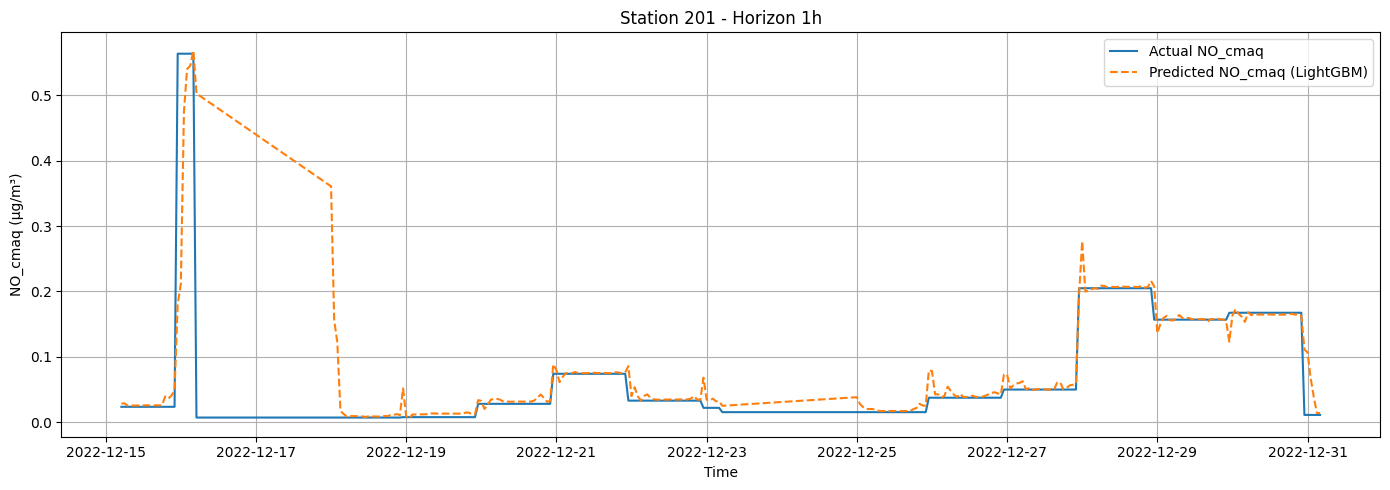

hour = 24


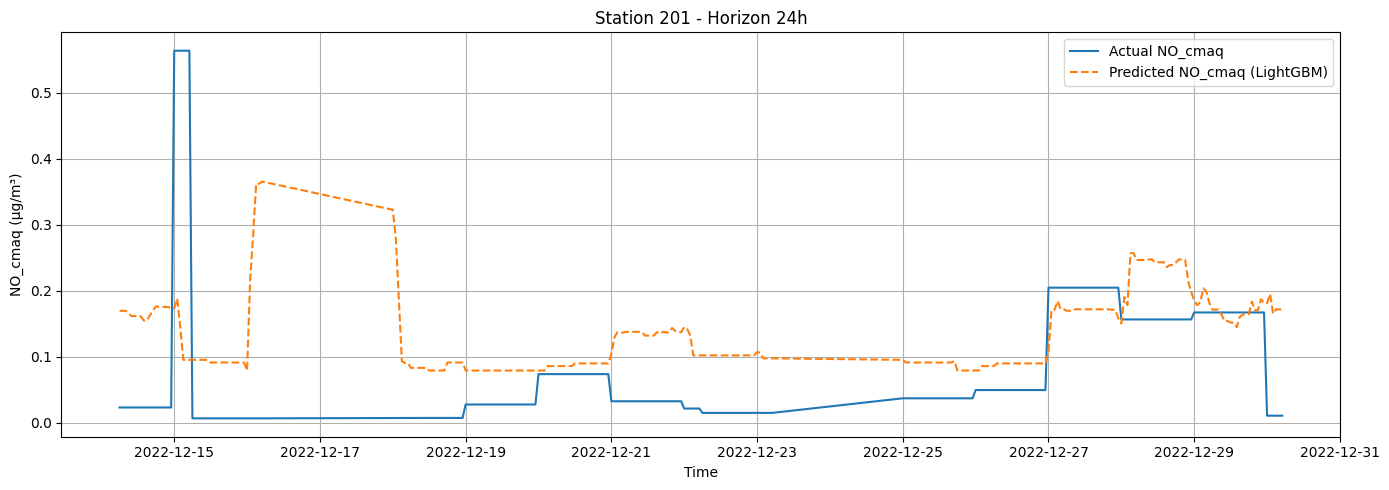

hour = 48


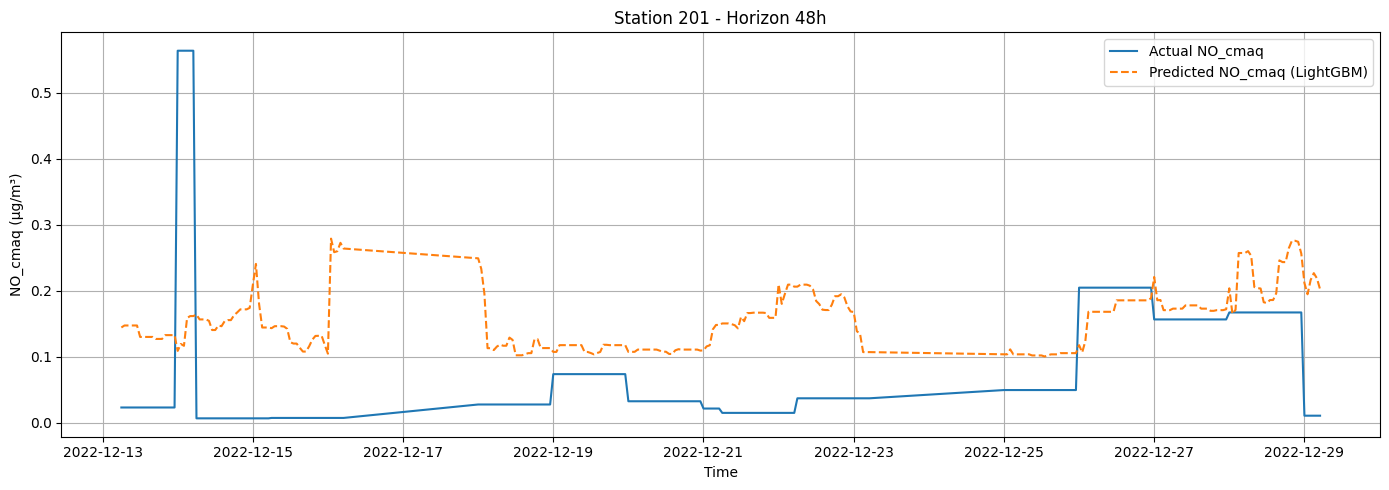

hour = 72


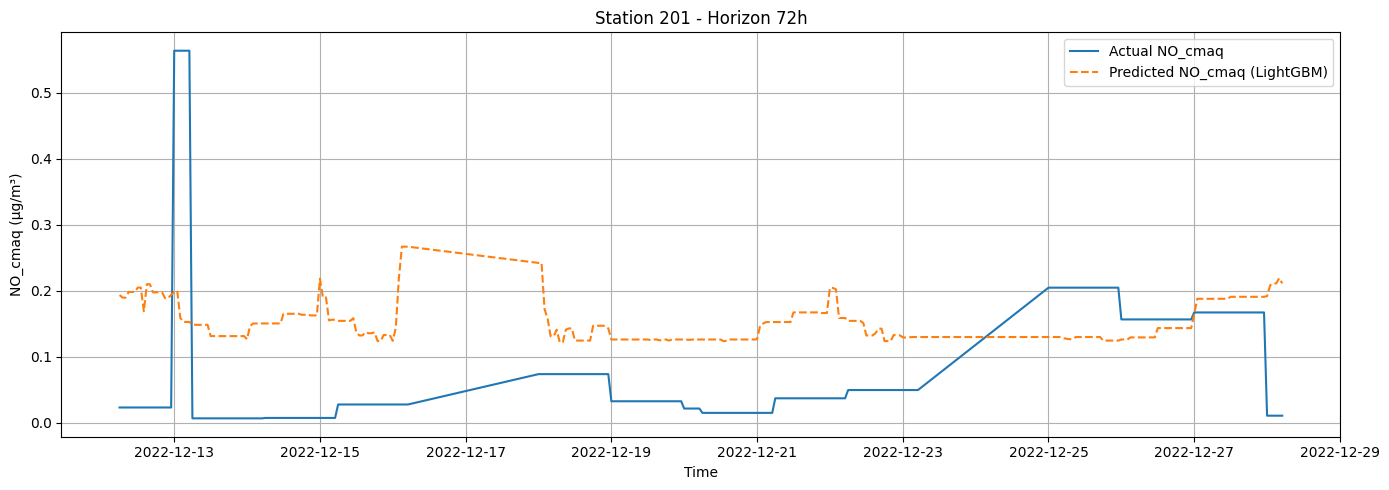

station_id = 211
hour = 1


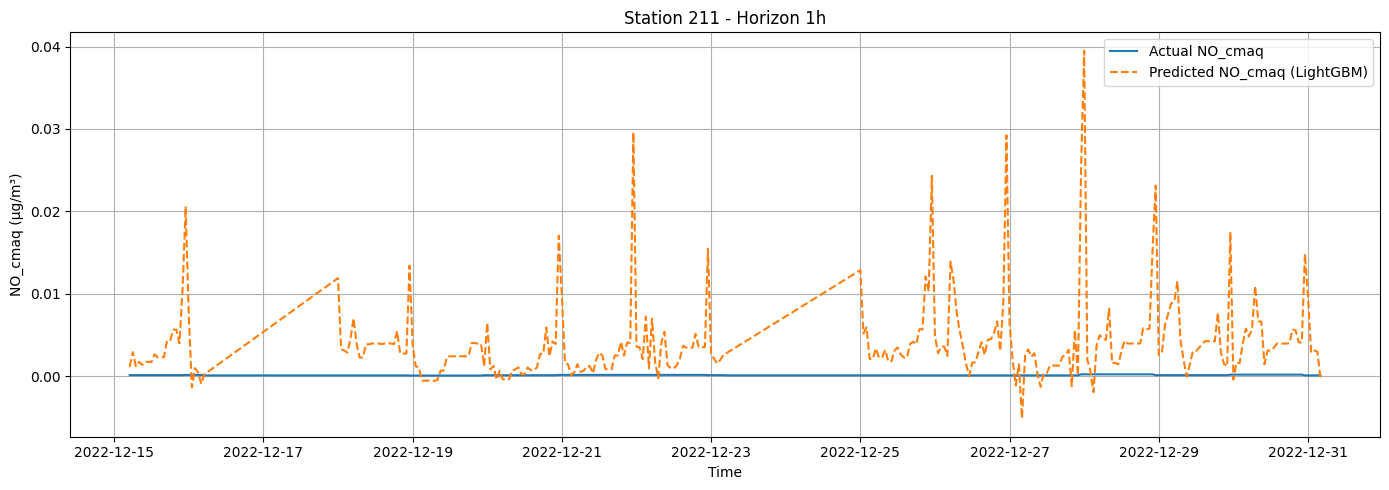

hour = 24


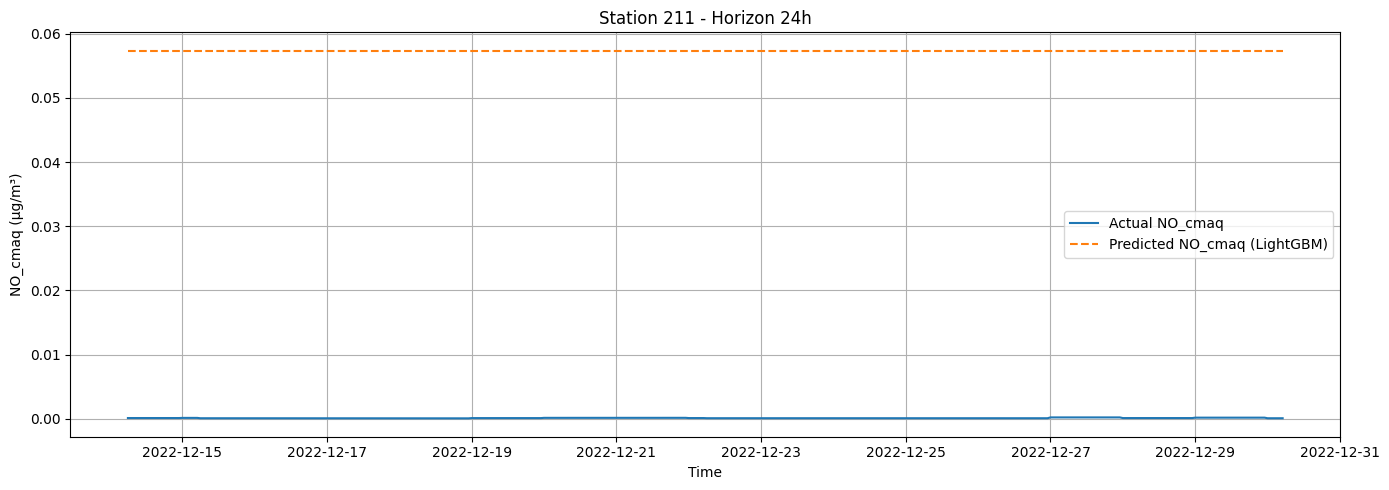

hour = 48


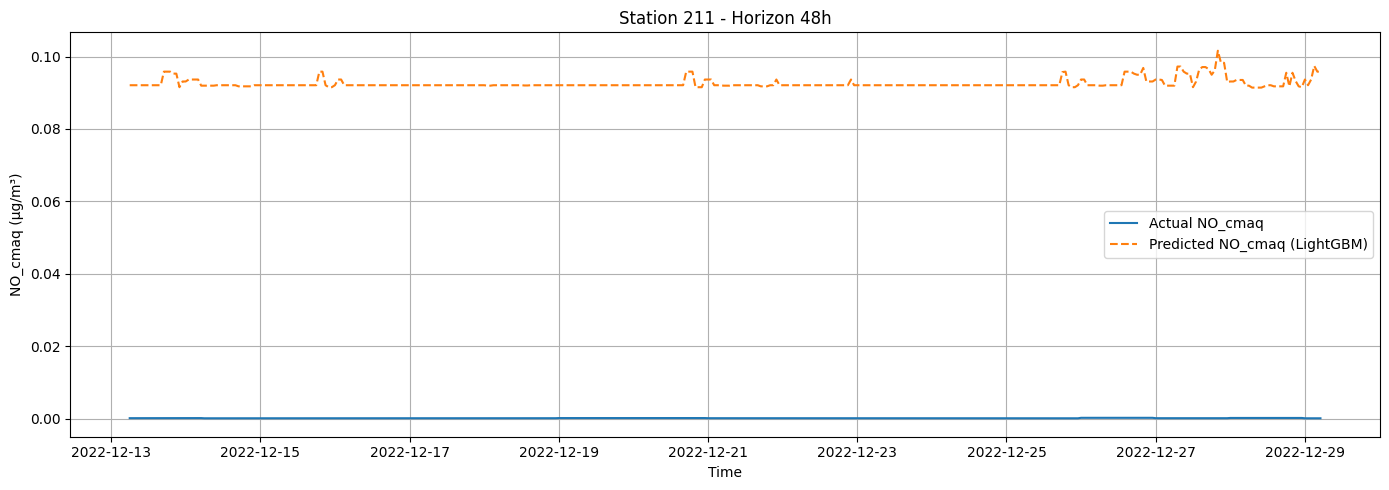

hour = 72


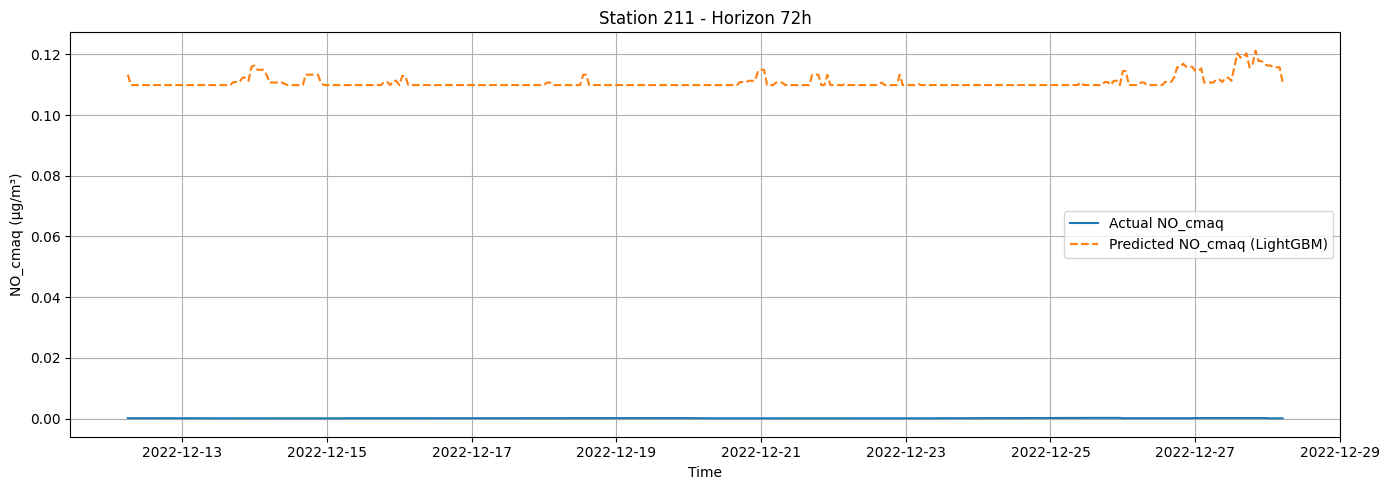

station_id = 212
hour = 1


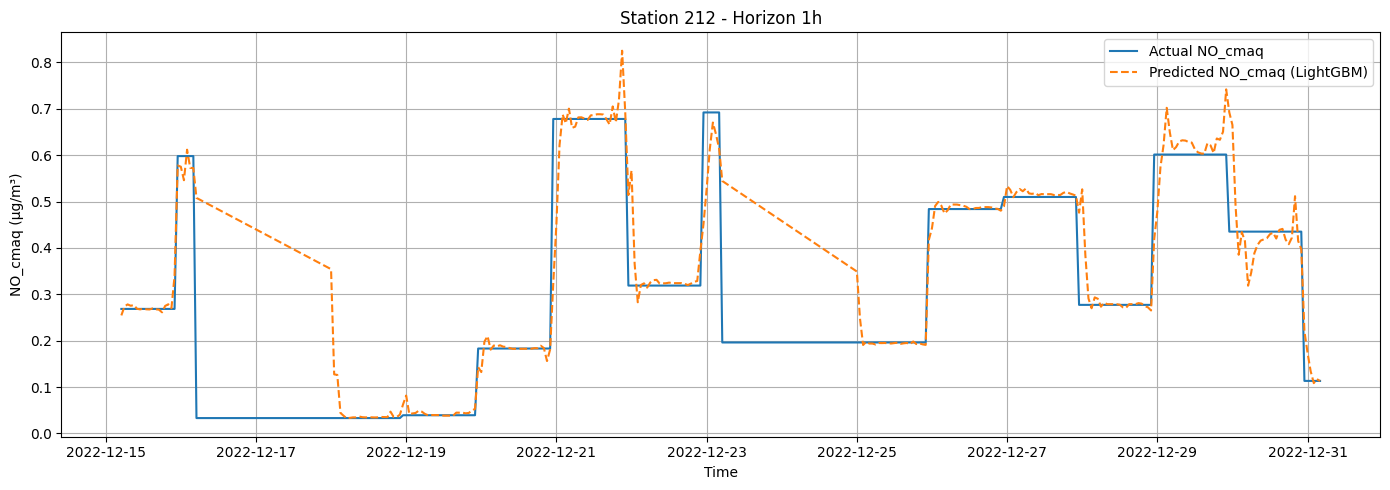

hour = 24


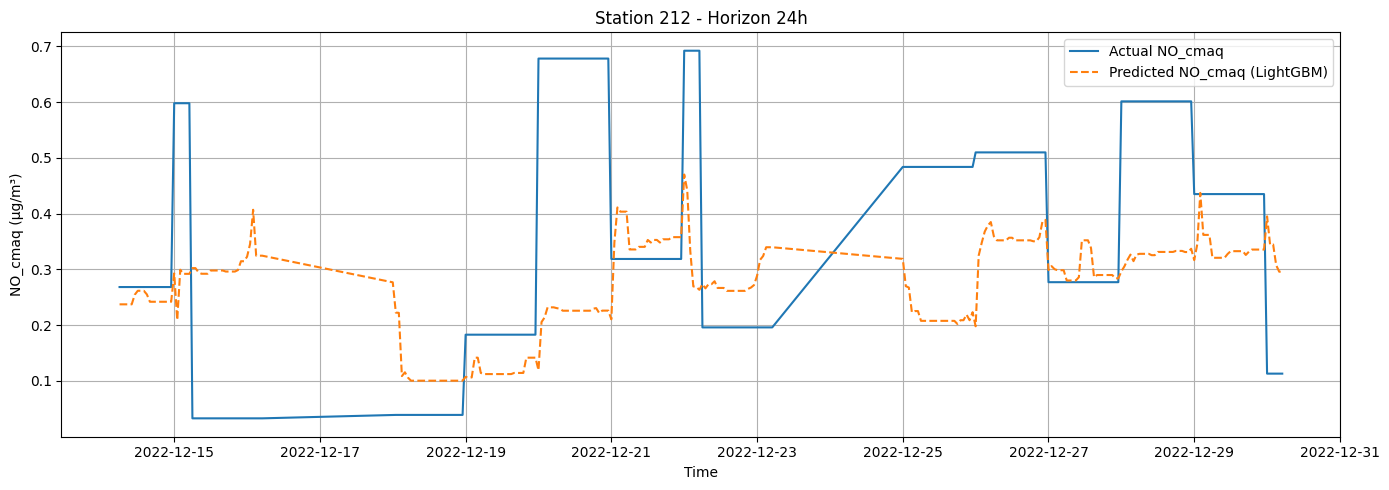

hour = 48


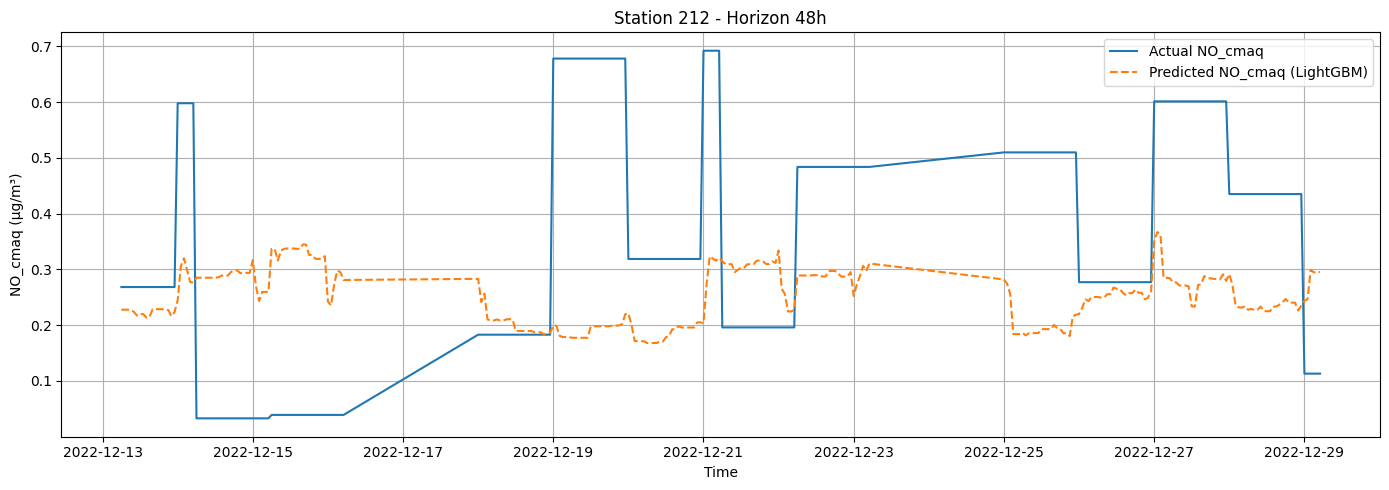

hour = 72


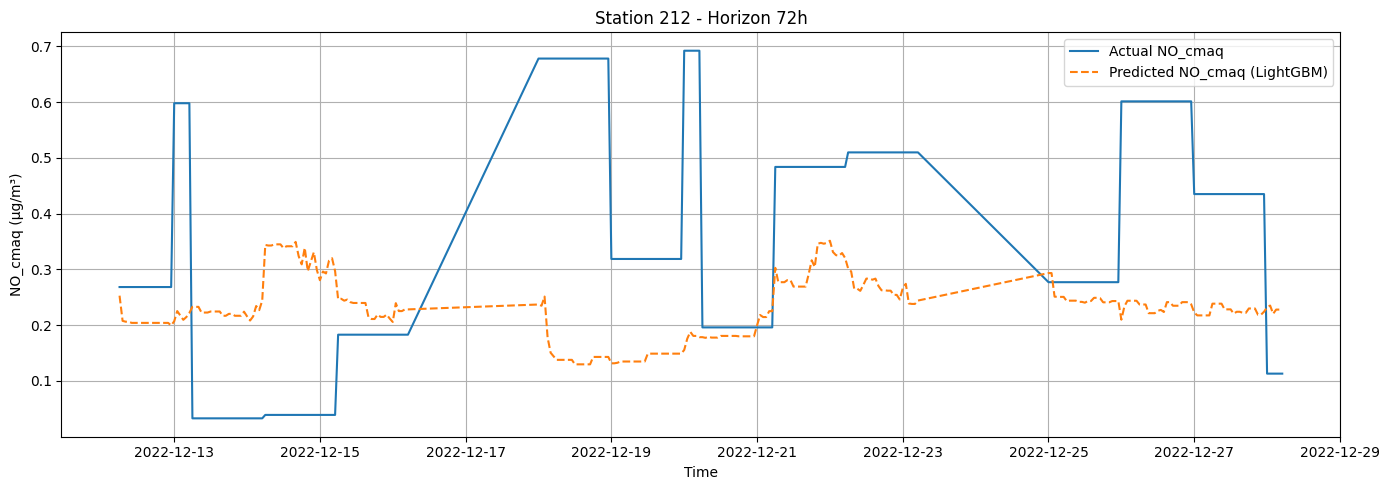

station_id = 213
hour = 1


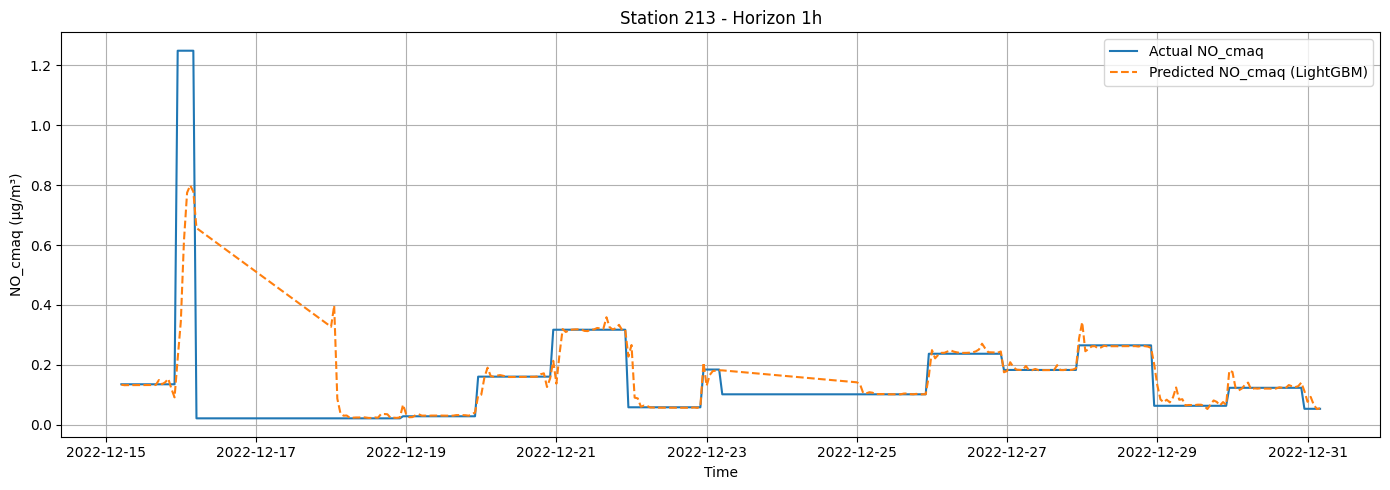

hour = 24


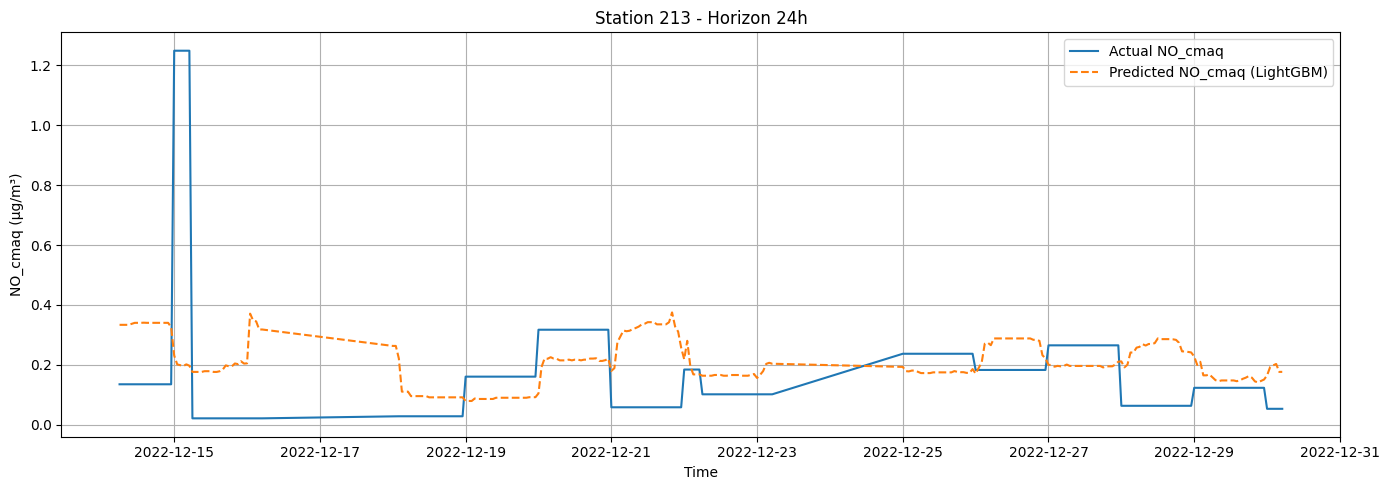

hour = 48


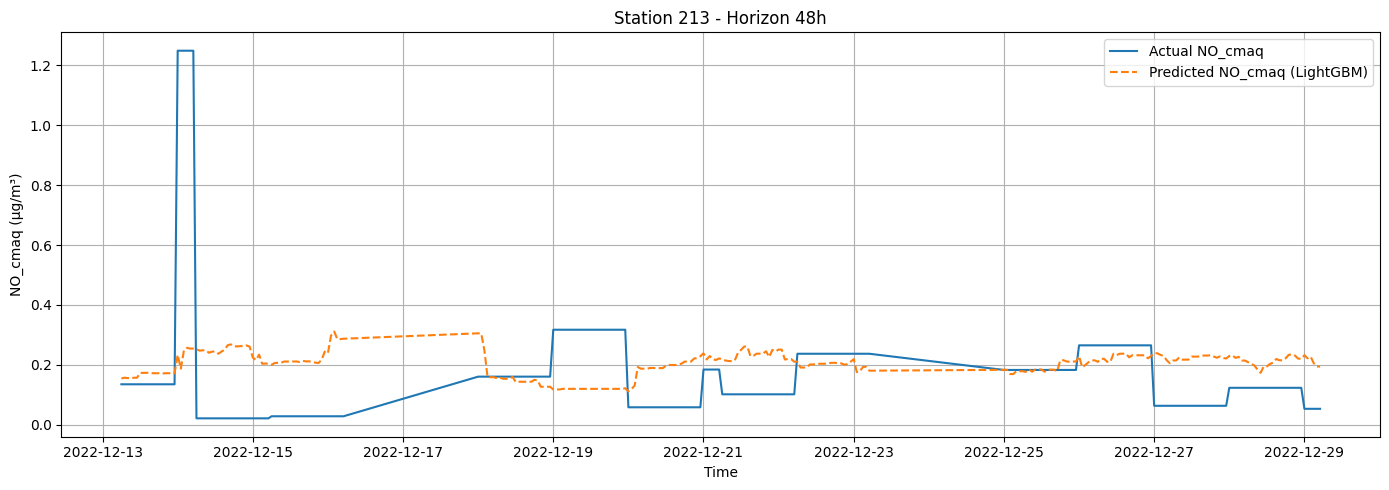

hour = 72


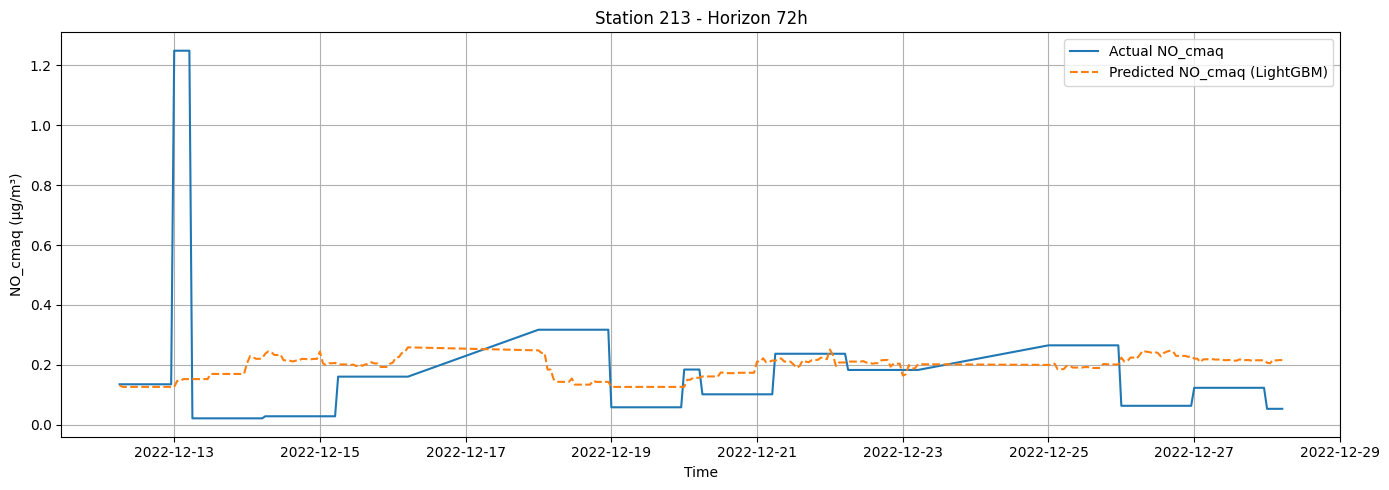

station_id = 214
hour = 1


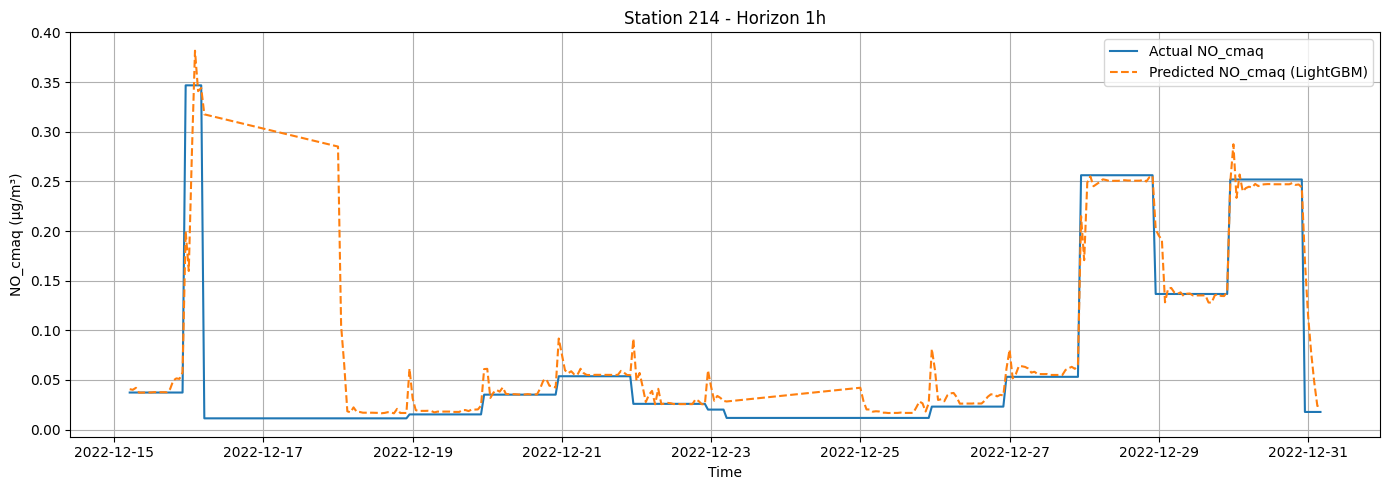

hour = 24


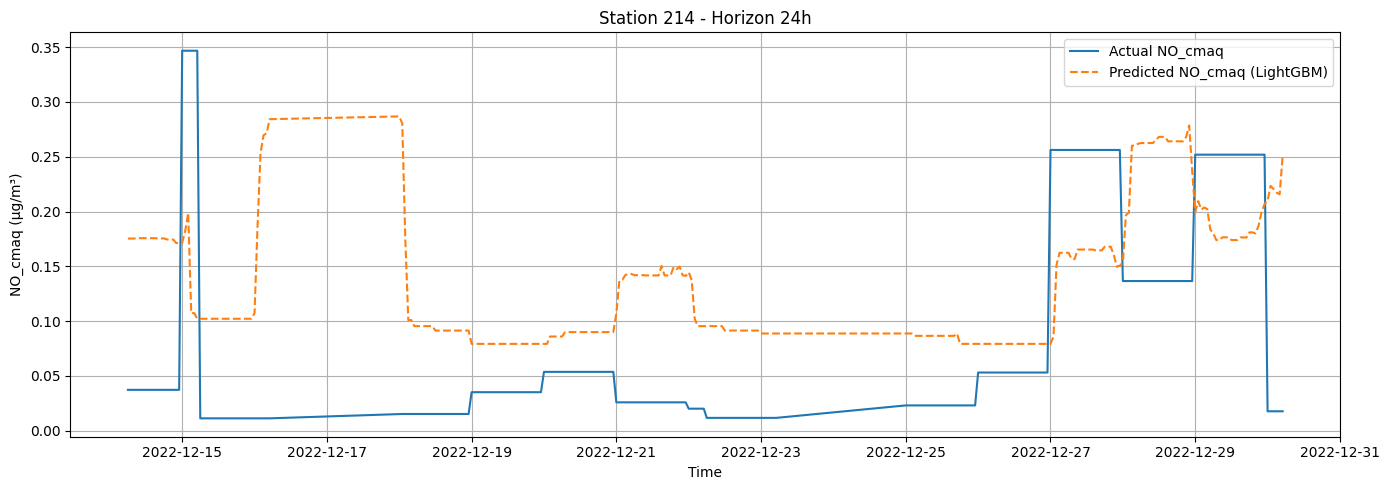

hour = 48


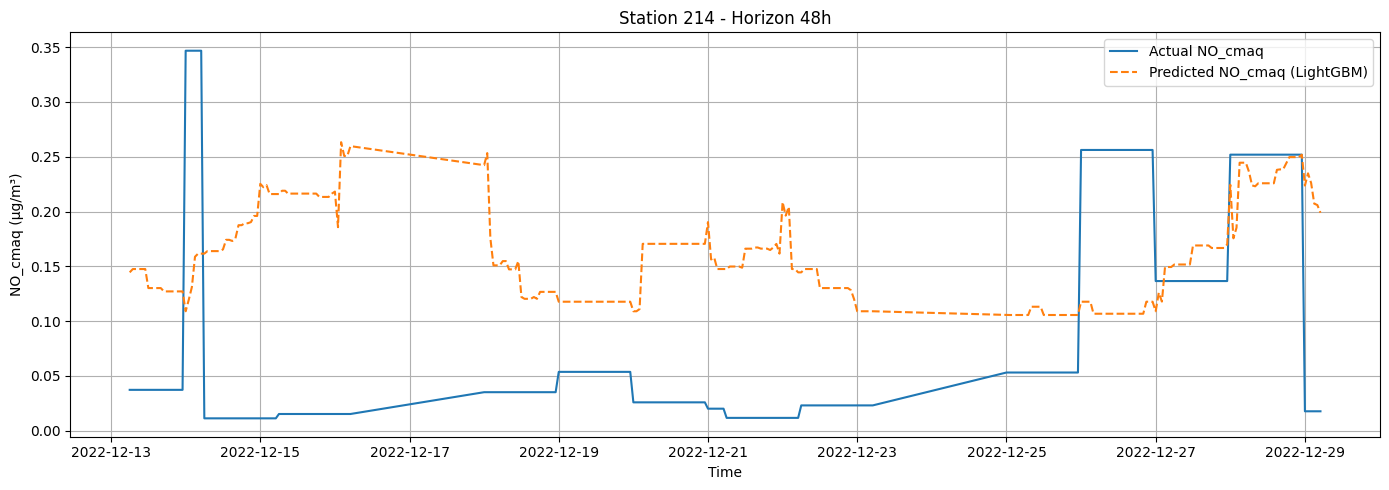

hour = 72


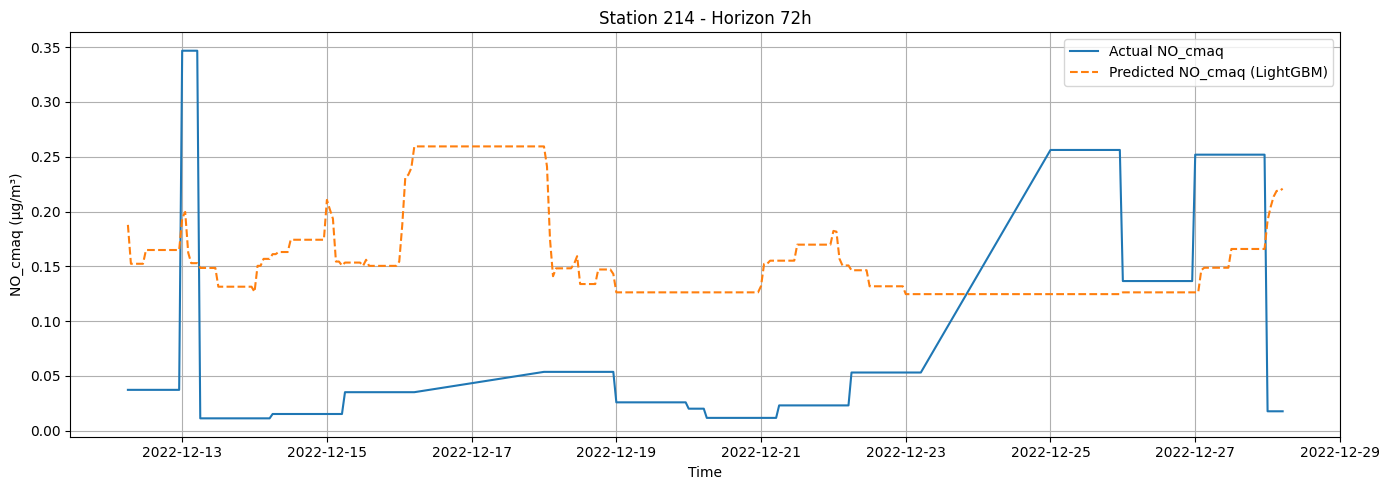

station_id = 215
hour = 1


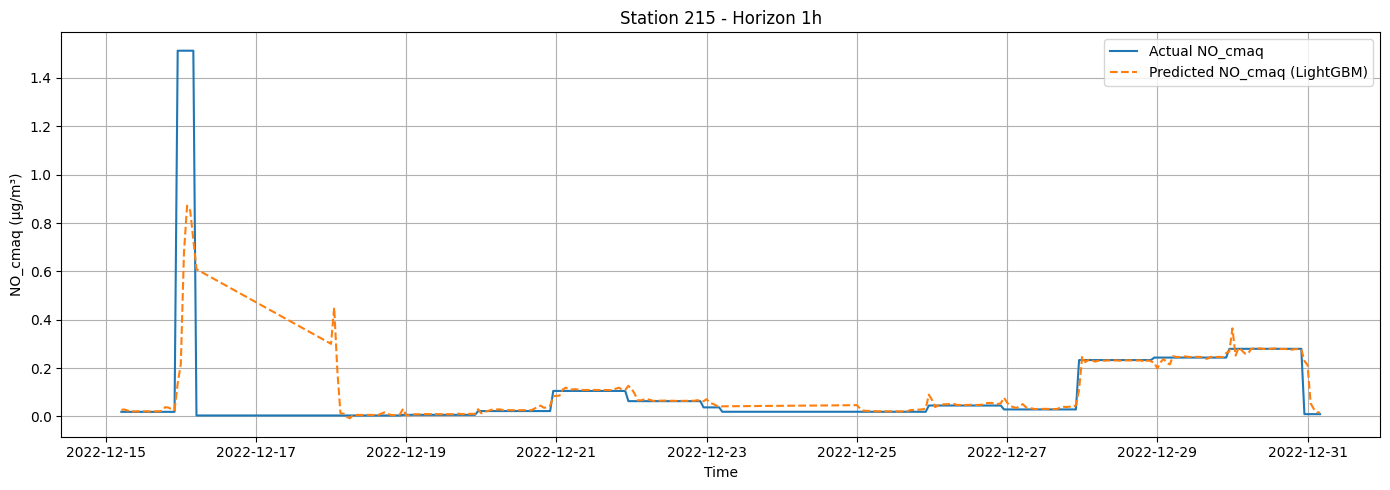

hour = 24


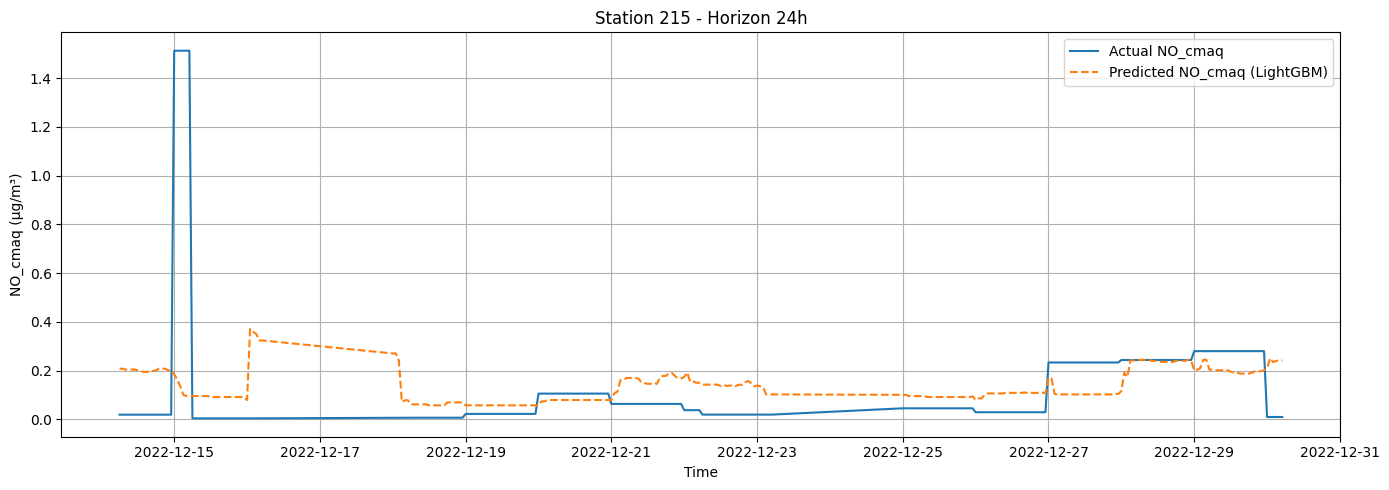

hour = 48


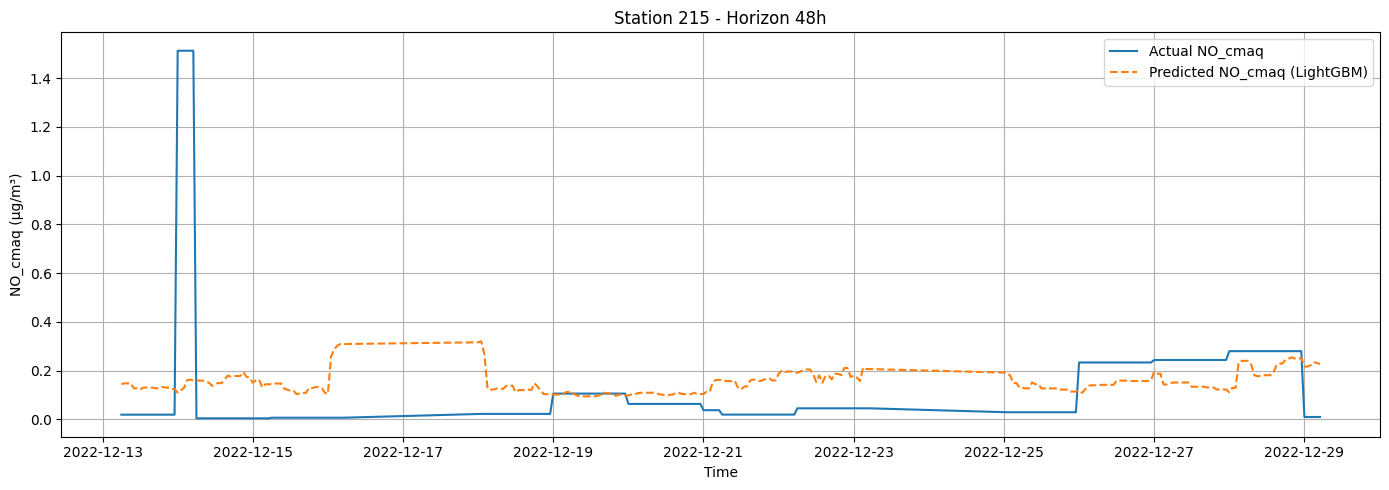

hour = 72


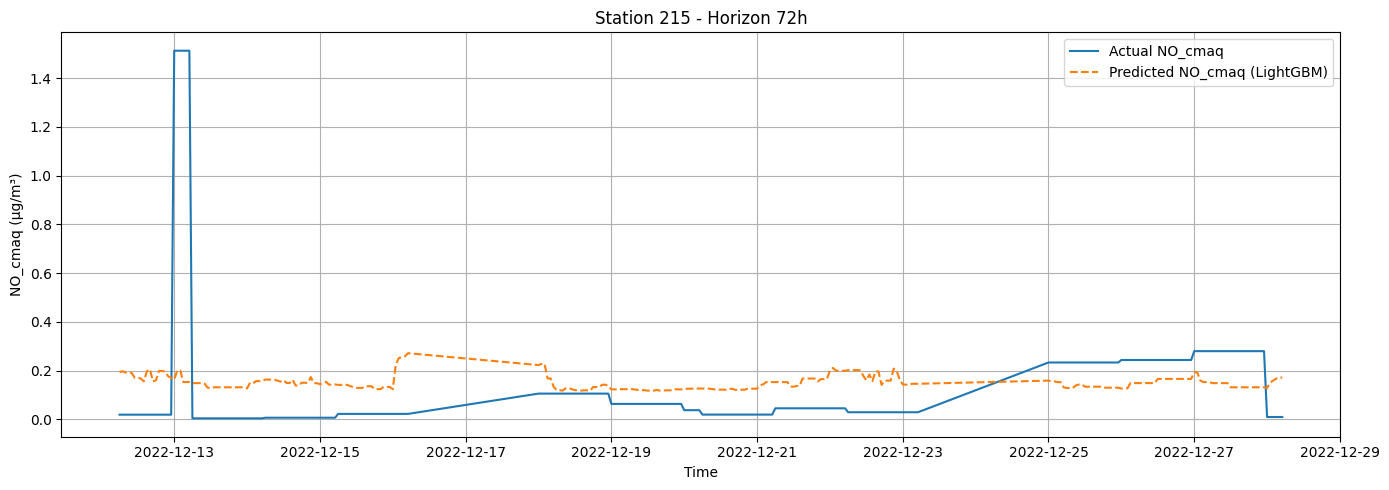

station_id = 216
hour = 1


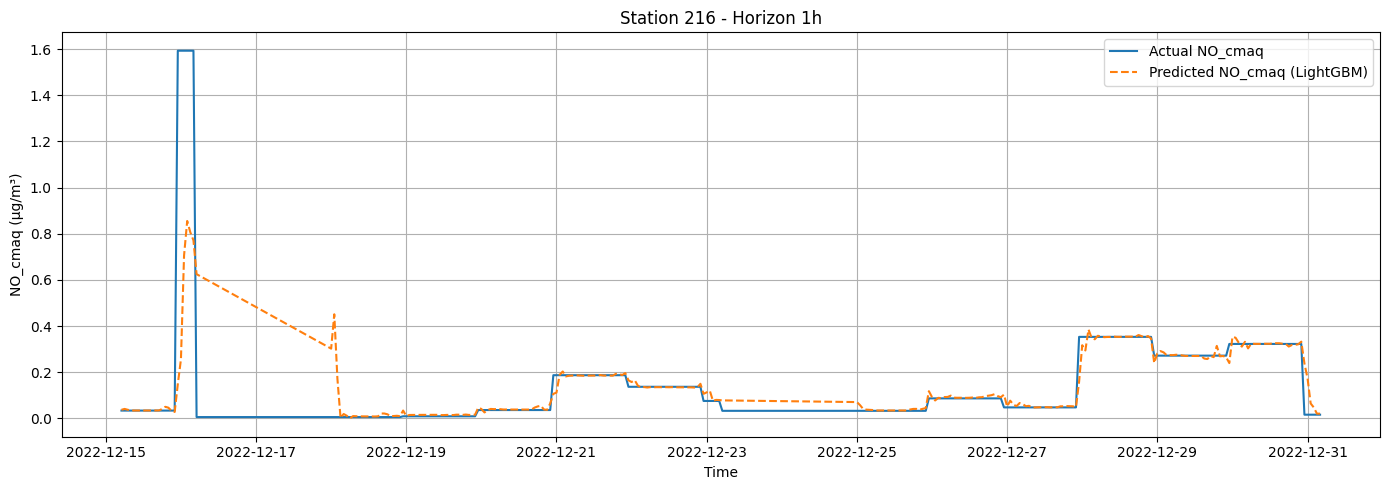

hour = 24


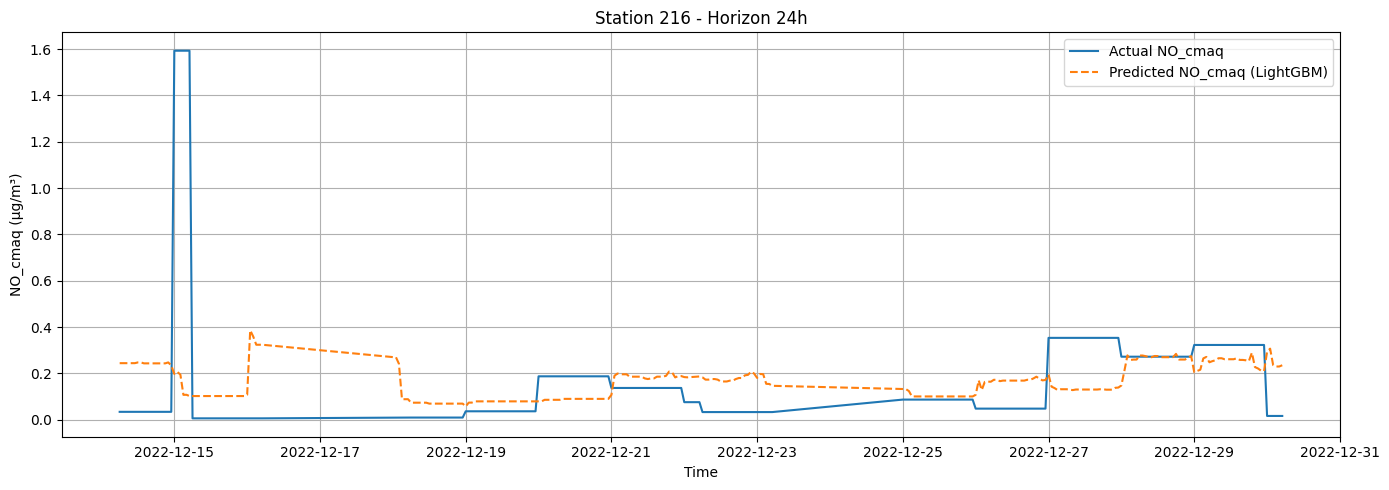

hour = 48


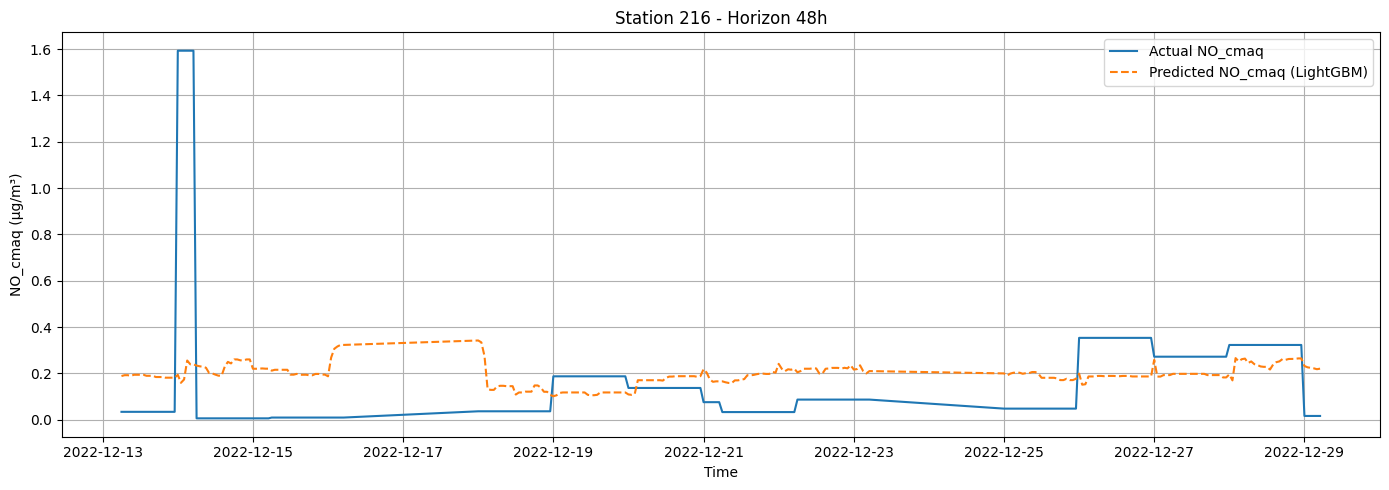

hour = 72


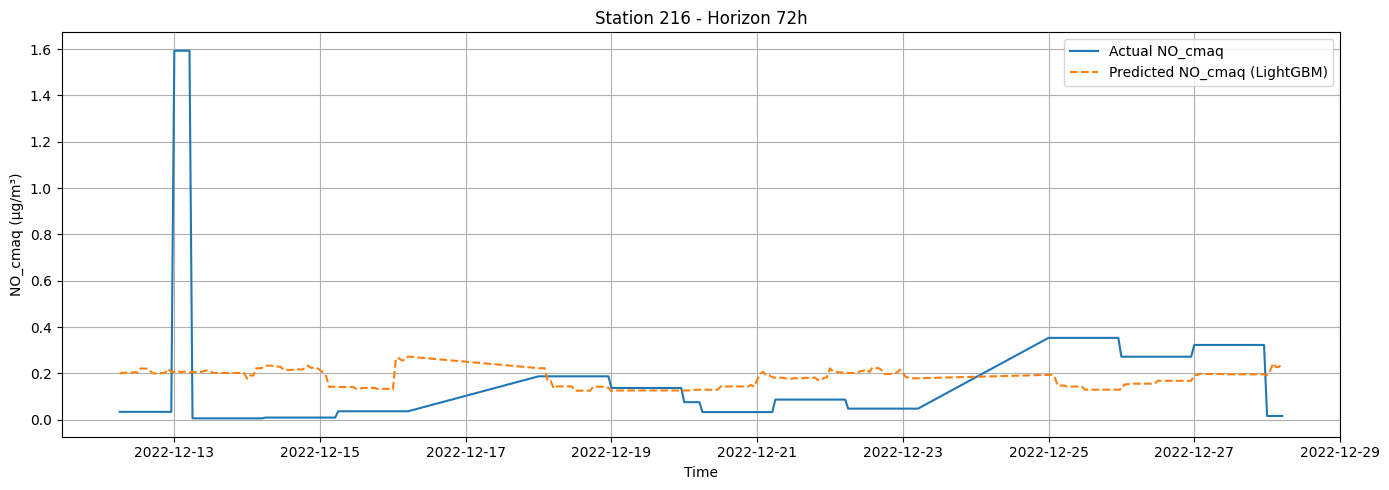

In [19]:
# Reference
for station_id in STATION_IDS:
    print(f"station_id = {station_id}")
    for hour in HORIZONS:
        print(f"hour = {hour}")
        plot_timeseries_example(df_so2, so2_models_by_h[hour], horizon_h=hour, station_id=station_id, target_col=label)